# **Import Libraries**

In [67]:
from urllib import request
import nltk
import random
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
from textblob import TextBlob
import wordcloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
from sklearn.model_selection import train_test_split, cross_validate, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_fscore_support, ConfusionMatrixDisplay, confusion_matrix, classification_report,f1_score
from mlxtend.evaluate import bias_variance_decomp
%matplotlib inline
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# **Get the raw text, partition it, label it**

## **Function to get the raw text from a Gutenberg book url**

In [68]:
def get_raw(url):
  response = request.urlopen(url) # open a connection to the specified url and get the server's response to the HTTP request
  raw = response.read().decode('utf-8-sig') # read the content of the HTTP response as a sequence of bytes and then decode these bytes into a Unicode string using the UTF-8 encoding. The result is the text content of the specified url.
  return raw

## **Function to get the part of the raw text between the end of the author name and the begining of the closing statement**

All Gutenberg books start with the opening statement  "START OF THE PROJECT GUTENBERG EBOOK" followed by the title and author name, and end with the closing statement "END OF THE PROJECT GUTENBERG EBOOK". To do any NLP effectively, we should extract partitions from the raw text that lies between the end of the author name and the begining of the closing statement.

In [69]:
def get_raw_from_author_to_closing(title,author,url):
  raw= get_raw(url)
  opening_statement= '.*start.*ebook.*\n' # lowercase since we will do the search with the lowercase version of the raw text to guarantee a match object
  closing_statement= '.*end.*ebook.*\n'  # lowercase since we will do the search with the lowercase version of the raw text to guarantee a match object

  start_position= re.search(opening_statement,raw.lower()).end() # start position is the end position of the opening statement
  if re.search(title.lower(),raw[start_position:].lower()): # if opening statement is followed by title
    start_position += re.search(title.lower(),raw[start_position:].lower()).end() # update start position to be end of title
    if re.search((author).lower(),raw[start_position:].lower()): # if title is followed by author name
      start_position += re.search((author).lower(),raw[start_position:].lower()).end() #update start position to be end of author name

  end_position= re.search(closing_statement,raw.lower()).start() # end position is the start position of the closing statement
  return raw[start_position:end_position]

## **Function to break down the raw text into a list of tokens i.e. words**

In [70]:
def get_tokens(raw):
  words= nltk.word_tokenize(raw)
  return words

## **Function to extract a specified number of random partitions from a book where each partition contains a specified number of words**

In [71]:
def extract_partitions(title,author,url,num_partitions,num_words_per_partition):
  raw= get_raw_from_author_to_closing(title,author,url) # get raw text from url
  words= get_tokens(raw) # get list of words/tokens from raw text
  partitions= []
  for i in range(num_partitions):
    start_index = random.randint(0, len(words) - num_words_per_partition) # generates a random starting index within the range of valid indices for the words list i.e. in such a way that the selected partition will not go beyond the end of the list
    partition = ' '.join(words[start_index:start_index + num_words_per_partition]) # Extracts a consecutive sequence of num_words_per_partition words starting from a the random position start_index and extending up to start_index + num_words_per_partition and joins the selected words into a single string by using space ' ' as a separator to form a sentence-like structure
    partitions.append(partition) # saves the partition in the list of partitions
  return partitions

## **Function to extract partitions from multiple books and label them as per the book they belong to**

In [72]:
def extract_from_multiple_books(books_details,num_partitions,num_words_per_partition):
  dict={'Partition':[],'Label':[], 'Book Title':[], 'Book Author':[]} # will be used to save each partition with its label and the title and author it belongs to
  for i in range(len(books_details)):
    partitions= extract_partitions(books_details[i]['title'],books_details[i]['author'],books_details[i]['url'],num_partitions,num_words_per_partition)
    for partition in partitions:
      dict['Partition'].append(partition)
      dict['Label'].append(books_details[i]['label'])
      dict['Book Title'].append(books_details[i]['title'])
      dict['Book Author'].append(books_details[i]['author'])
  return dict

## **Function to extract partitions from multiple books and save them in a dataframe and csv file**

In [73]:
def extract_and_save(books_details,num_partitions,num_words_per_partition):
  dict= extract_from_multiple_books(books_details,num_partitions,num_words_per_partition)

  # Assign series for partitions, labels, titles, and authors
  partitions= pd.Series(dict['Partition'])
  labels= pd.Series(dict['Label'])
  titles= pd.Series(dict['Book Title'])
  authors= pd.Series(dict['Book Author'])

  # Construct a data frame from the above series
  data= pd.DataFrame({'Book Title':titles, 'Book Author':authors, 'Label':labels, 'Partition':partitions })

  # Save the data to a csv file
  data.to_csv('sample_partitions.csv', index=False, encoding= 'utf-8-sig')
  return data

## **Extraction of 200 random partitions of 100 words each from 6 books from Gutenberg's Digital Collection belonging to the  Harvard Classics Genre**

In [74]:
# Book 1 Details https://www.gutenberg.org/cache/epub/3695/pg3695.txt
url1 = 'https://www.gutenberg.org/cache/epub/4081/pg4081.txt'
title1= 'The Alchemist'
author1= 'Ben Jonson'
label1= 'a'
dict1= {'title':title1, 'author':author1, 'url':url1, 'label':label1}

# Book 2 Details
url2= 'https://www.gutenberg.org/cache/epub/1656/pg1656.txt'
title2= 'Apology'
author2= 'Plato'
label2= 'b'
dict2= {'title':title2, 'author':author2, 'url':url2, 'label':label2}

# Book 3 Details
url3= 'https://www.gutenberg.org/cache/epub/996/pg996.txt'
title3= 'Don Quixote'
author3= 'Miguel de Cervantes Saavedra'
label3= 'c'
dict3= {'title':title3, 'author':author3, 'url':url3, 'label':label3}

# Book 4 Details
url4= 'https://www.gutenberg.org/cache/epub/766/pg766.txt'
title4= 'David Copperfield'
author4= 'Charles Dickens'
label4= 'd'
dict4= {'title':title4, 'author':author4, 'url':url4, 'label':label4}

# Book 5 Details
url5= 'https://www.gutenberg.org/cache/epub/1727/pg1727.txt'
title5= 'The Odyssey'
author5= 'Homer'
label5= 'e'
dict5= {'title':title5, 'author':author5, 'url':url5, 'label':label5}

# Book 6 Details
url6= 'https://www.gutenberg.org/cache/epub/2554/pg2554.txt'
title6= 'Crime and Punishment'
author6= 'Fyodor Dostoyevsky'
label6= 'f'
dict6= {'title':title6, 'author':author6, 'url':url6, 'label':label6}

# All Books Details
books_details= [dict1, dict2, dict3, dict4,dict5, dict6]
books_details

[{'title': 'The Alchemist',
  'author': 'Ben Jonson',
  'url': 'https://www.gutenberg.org/cache/epub/4081/pg4081.txt',
  'label': 'a'},
 {'title': 'Apology',
  'author': 'Plato',
  'url': 'https://www.gutenberg.org/cache/epub/1656/pg1656.txt',
  'label': 'b'},
 {'title': 'Don Quixote',
  'author': 'Miguel de Cervantes Saavedra',
  'url': 'https://www.gutenberg.org/cache/epub/996/pg996.txt',
  'label': 'c'},
 {'title': 'David Copperfield',
  'author': 'Charles Dickens',
  'url': 'https://www.gutenberg.org/cache/epub/766/pg766.txt',
  'label': 'd'},
 {'title': 'The Odyssey',
  'author': 'Homer',
  'url': 'https://www.gutenberg.org/cache/epub/1727/pg1727.txt',
  'label': 'e'},
 {'title': 'Crime and Punishment',
  'author': 'Fyodor Dostoyevsky',
  'url': 'https://www.gutenberg.org/cache/epub/2554/pg2554.txt',
  'label': 'f'}]

In [75]:
data= extract_and_save(books_details,num_partitions=200,num_words_per_partition=100)

In [76]:
data

,Book Title,Book Author,Label,Partition
0,The Alchemist,Ben Jonson,a,"about it Of silver , should have run with crea..."
1,The Alchemist,Ben Jonson,a,"piece of money , many coins being stamped with..."
2,The Alchemist,Ben Jonson,a,"Why Dol 's employ 'd , you know . SUB . That '..."
3,The Alchemist,Ben Jonson,a,graces pass the hours ? I see You are lodged h...
4,The Alchemist,Ben Jonson,a,cream does look like opals ; and with these De...
...,...,...,...,...
1195,Crime and Punishment,Fyodor Dostoyevsky,f,man on what they have against me . Enough .......
1196,Crime and Punishment,Fyodor Dostoyevsky,f,to anticipate contingencies by seeking the fav...
1197,Crime and Punishment,Fyodor Dostoyevsky,f,the shawl dance at the breaking-up ? ’ ( You m...
1198,Crime and Punishment,Fyodor Dostoyevsky,f,“ What if ... how could I let him go off alone...


# **Clean up the data: remove punctuation, tokenize, remove stopwords, stem/lemmatize**

In [77]:
def clean_text_stem(text):
  text= text.lower()
  text= ''.join([char for char in text if char not in (string.punctuation + "‘’“”") ]) # remove punctuation to prevent tokenize function from considering them as words
  tokens= get_tokens(text)
  text_nostop= [word for word in tokens if word not in nltk.corpus.stopwords.words('english')]
  text_stemmed=' '.join([nltk.PorterStemmer().stem(word) for word in text_nostop])
  return text_stemmed

def clean_text_lem(text):
  text= text.lower()
  text= ''.join([char for char in text if char not in (string.punctuation + "‘’“”") ]) # remove punctuation to prevent tokenize function from considering them as words
  tokens= get_tokens(text)
  text_nostop= [word for word in tokens if word not in nltk.corpus.stopwords.words('english')]
  text_lemmatized= ' '.join([nltk.WordNetLemmatizer().lemmatize(word) for word in text_nostop])
  return text_lemmatized

data['Partition_stemmed']= data['Partition'].apply(lambda x: clean_text_stem(x))
data['Partition_lemmatized']= data['Partition'].apply(lambda x: clean_text_lem(x))
data

,Book Title,Book Author,Label,Partition,Partition_stemmed,Partition_lemmatized
0,The Alchemist,Ben Jonson,a,"about it Of silver , should have run with crea...",silver run cream hogsden everi sunday moorfiel...,silver run cream hogsden every sunday moorfiel...
1,The Alchemist,Ben Jonson,a,"piece of money , many coins being stamped with...",piec money mani coin stamp cross cross pile he...,piece money many coin stamped cross cross pile...
2,The Alchemist,Ben Jonson,a,"Why Dol 's employ 'd , you know . SUB . That '...",dol employ know sub true fore heaven know must...,dol employ know sub true fore heaven know must...
3,The Alchemist,Ben Jonson,a,graces pass the hours ? I see You are lodged h...,grace pass hour see lodg hous rare man excel a...,grace pas hour see lodged house rare man excel...
4,The Alchemist,Ben Jonson,a,cream does look like opals ; and with these De...,cream look like opal delic meat set high pleas...,cream look like opal delicate meat set high pl...
...,...,...,...,...,...,...
1195,Crime and Punishment,Fyodor Dostoyevsky,f,man on what they have against me . Enough .......,man enough tell may know tri manag somehow put...,man enough tell may know try manage somehow pu...
1196,Crime and Punishment,Fyodor Dostoyevsky,f,to anticipate contingencies by seeking the fav...,anticip conting seek favour younger gener reli...,anticipate contingency seeking favour younger ...
1197,Crime and Punishment,Fyodor Dostoyevsky,f,the shawl dance at the breaking-up ? ’ ( You m...,shawl danc breakingup must mend tear must take...,shawl dance breakingup must mend tear must tak...
1198,Crime and Punishment,Fyodor Dostoyevsky,f,“ What if ... how could I let him go off alone...,could let go alon may drown ach blunder ran ba...,could let go alone may drown ach blunder ran b...


# **Data Analysis**

## **Length Analysis**

Examining the length of the text is crucial, as it entails a straightforward calculation that can yield valuable insights. For instance, the length itself might become the sole feature necessary for model construction.

Various measures exist for assessing the length of text data. Several examples include:

Word count: This involves tallying the number of tokens in the text, with tokens being separated by spaces.

Character count: It entails summing the number of characters in each token.

Sentence count: This measure involves counting the number of sentences, with sentences separated by periods.

Average word length: Calculated as the sum of word lengths divided by the total number of words, where word lengths are determined by the character count.

Average sentence length: Determined by dividing the sum of sentence lengths by the total number of sentences, where sentence lengths are measured in terms of word count.

In [78]:
# New features: Word count, Character count, Sentence count, Average word length, Average sentence length
data['Word_count']= data['Partition_lemmatized'].apply(lambda x: len(x.split(" ")))
data['Character_count']= data['Partition_lemmatized'].apply(lambda x: sum(len(word) for word in x.split(" ")))
data ['Sentence_count']= data['Partition'].apply(lambda x: len(x.split(".")))
data['Avg_word_length']= data['Character_count']/data['Word_count']
data['Avg_sentence_length']= data['Word_count']/data['Sentence_count']

In [79]:
data

,Book Title,Book Author,Label,Partition,Partition_stemmed,Partition_lemmatized,Word_count,Character_count,Sentence_count,Avg_word_length,Avg_sentence_length
0,The Alchemist,Ben Jonson,a,"about it Of silver , should have run with crea...",silver run cream hogsden everi sunday moorfiel...,silver run cream hogsden every sunday moorfiel...,40,193,5,4.825000,8.000000
1,The Alchemist,Ben Jonson,a,"piece of money , many coins being stamped with...",piec money mani coin stamp cross cross pile he...,piece money many coin stamped cross cross pile...,45,271,11,6.022222,4.090909
2,The Alchemist,Ben Jonson,a,"Why Dol 's employ 'd , you know . SUB . That '...",dol employ know sub true fore heaven know must...,dol employ know sub true fore heaven know must...,34,163,13,4.794118,2.615385
3,The Alchemist,Ben Jonson,a,graces pass the hours ? I see You are lodged h...,grace pass hour see lodg hous rare man excel a...,grace pas hour see lodged house rare man excel...,36,191,6,5.305556,6.000000
4,The Alchemist,Ben Jonson,a,cream does look like opals ; and with these De...,cream look like opal delic meat set high pleas...,cream look like opal delicate meat set high pl...,45,229,5,5.088889,9.000000
...,...,...,...,...,...,...,...,...,...,...,...
1195,Crime and Punishment,Fyodor Dostoyevsky,f,man on what they have against me . Enough .......,man enough tell may know tri manag somehow put...,man enough tell may know try manage somehow pu...,26,135,24,5.192308,1.083333
1196,Crime and Punishment,Fyodor Dostoyevsky,f,to anticipate contingencies by seeking the fav...,anticip conting seek favour younger gener reli...,anticipate contingency seeking favour younger ...,40,304,5,7.600000,8.000000
1197,Crime and Punishment,Fyodor Dostoyevsky,f,the shawl dance at the breaking-up ? ’ ( You m...,shawl danc breakingup must mend tear must take...,shawl dance breakingup must mend tear must tak...,39,235,5,6.025641,7.800000
1198,Crime and Punishment,Fyodor Dostoyevsky,f,“ What if ... how could I let him go off alone...,could let go alon may drown ach blunder ran ba...,could let go alone may drown ach blunder ran b...,39,219,12,5.615385,3.250000


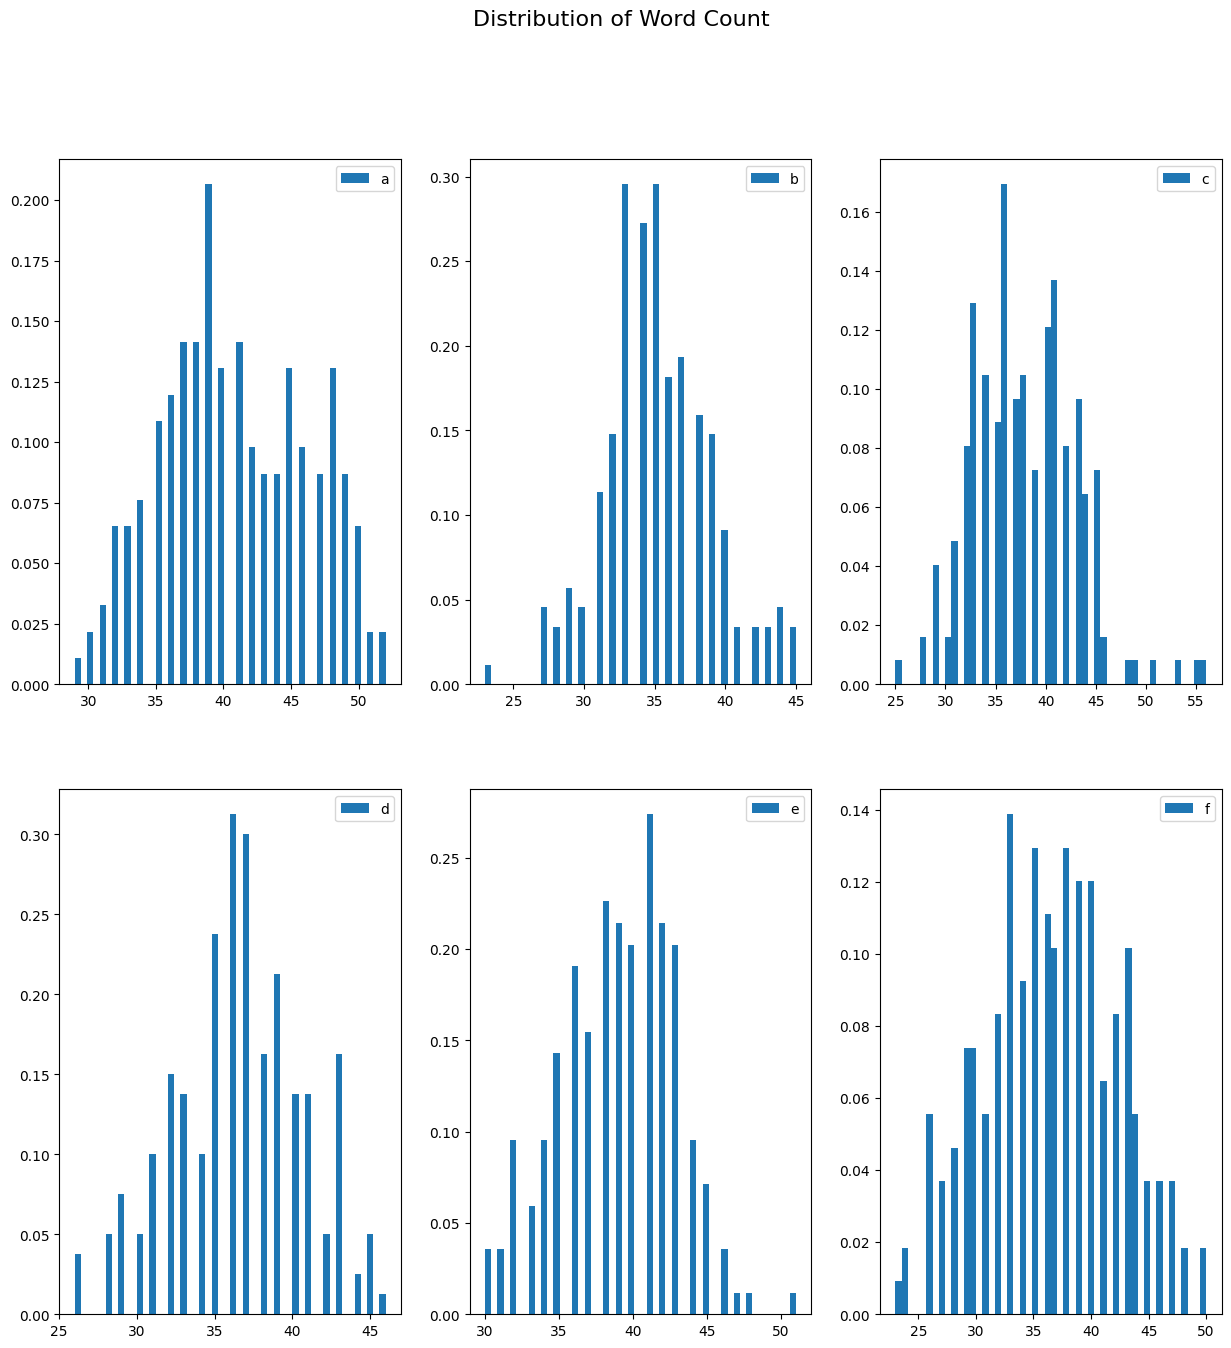

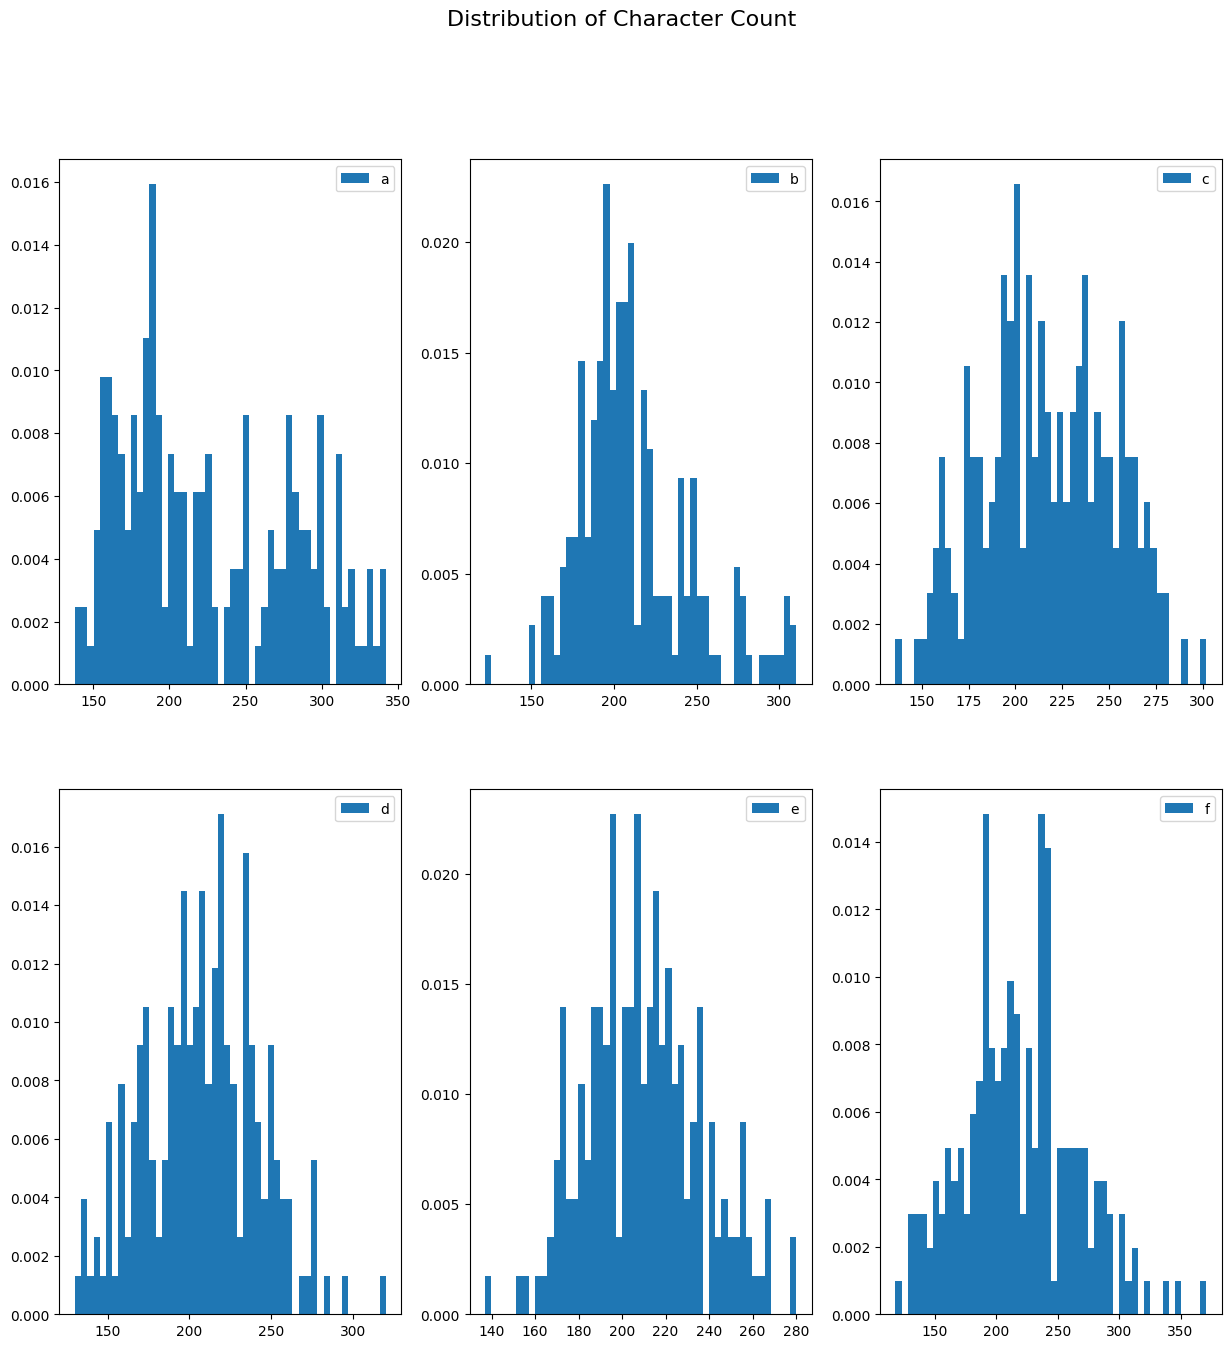

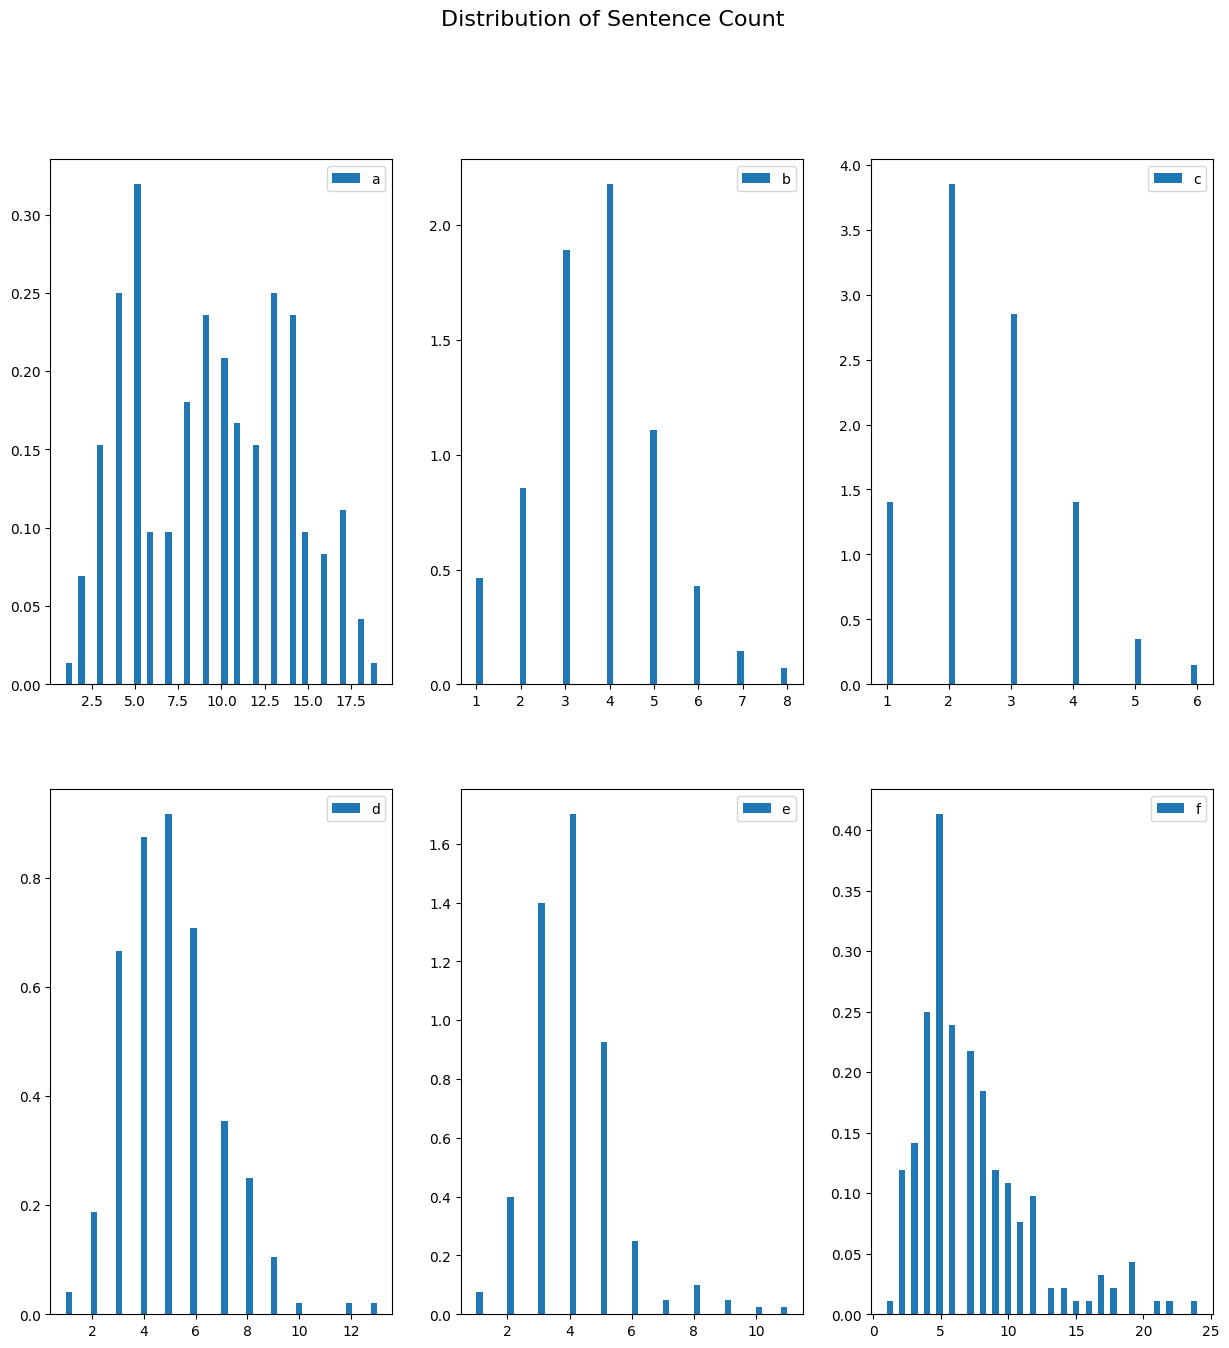

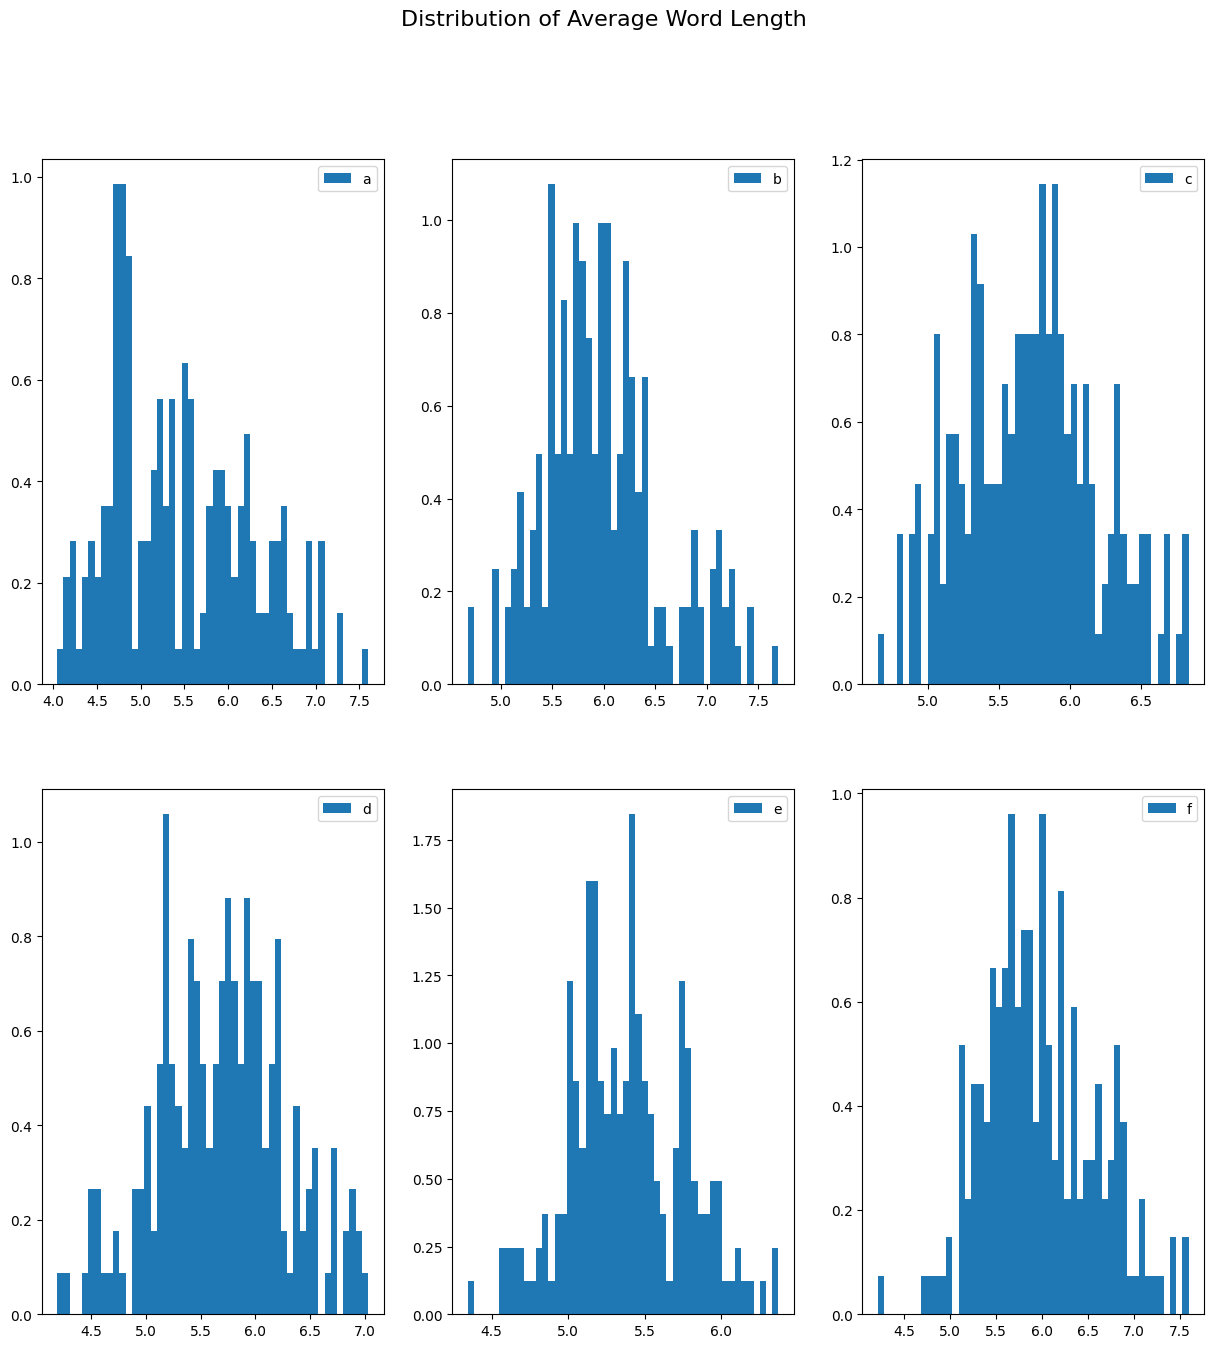

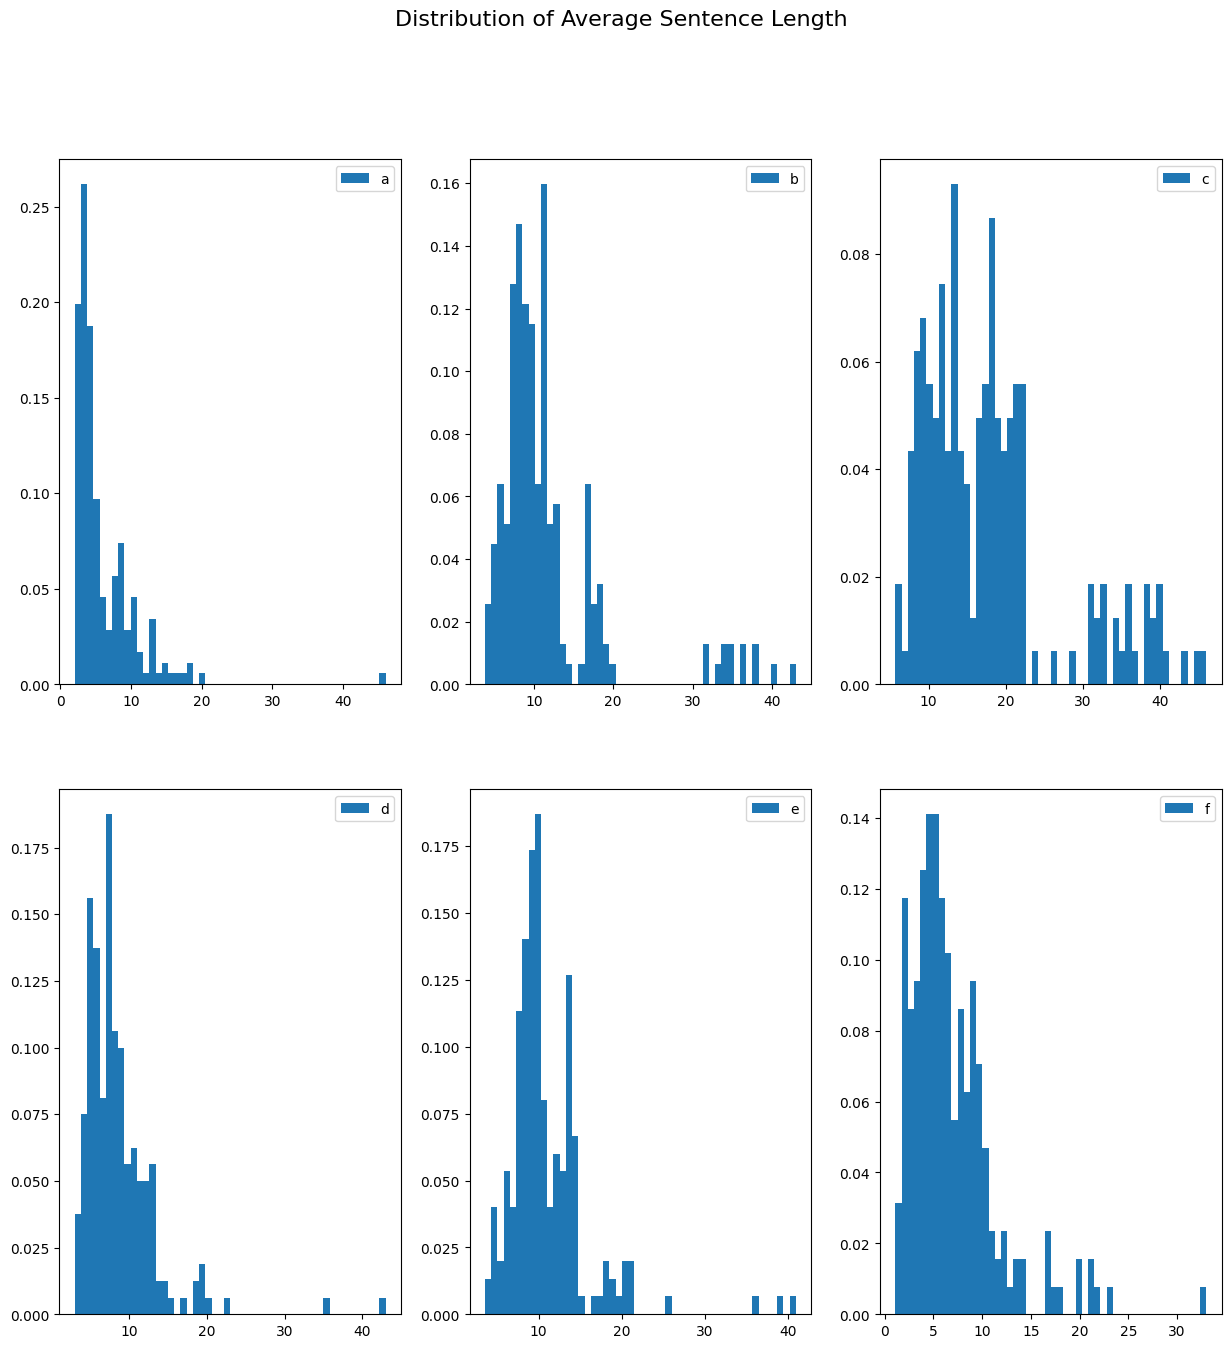

In [80]:
# Evaluation of new features using histograms:
Labels= data['Label'].unique()

# Distribution of Word Count
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))  # Adjust the width and height as needed
fig.suptitle('Distribution of Word Count', fontsize=16)
for i in range(2):
  for j in range(3):
    axes[i,j].hist(data[data['Label']==Labels[np.ravel_multi_index((i,j), (2,3))]]['Word_count'], bins=50, density=True, label= Labels[np.ravel_multi_index((i,j), (2,3))]) # alpha tells how dark the shade of the histogram must be, normed= True to normalize our plots to the same scale because there is a lot more ham than spam
    axes[i,j].legend(loc='upper right')
plt.show()

# Distribution of Character Count
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))  # Adjust the width and height as needed
fig.suptitle('Distribution of Character Count', fontsize=16)
for i in range(2):
  for j in range(3):
    axes[i,j].hist(data[data['Label']==Labels[np.ravel_multi_index((i,j), (2,3))]]['Character_count'], bins=50, density=True, label= Labels[np.ravel_multi_index((i,j), (2,3))]) # alpha tells how dark the shade of the histogram must be, normed= True to normalize our plots to the same scale because there is a lot more ham than spam
    axes[i,j].legend(loc='upper right')
plt.show()

# Distribution of Sentence Count
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))  # Adjust the width and height as needed
fig.suptitle('Distribution of Sentence Count', fontsize=16)
for i in range(2):
  for j in range(3):
    axes[i,j].hist(data[data['Label']==Labels[np.ravel_multi_index((i,j), (2,3))]]['Sentence_count'], bins=50, density=True, label= Labels[np.ravel_multi_index((i,j), (2,3))]) # alpha tells how dark the shade of the histogram must be, normed= True to normalize our plots to the same scale because there is a lot more ham than spam
    axes[i,j].legend(loc='upper right')
plt.show()

# Distribution of Average Word Length
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))  # Adjust the width and height as needed
fig.suptitle('Distribution of Average Word Length', fontsize=16)
for i in range(2):
  for j in range(3):
    axes[i,j].hist(data[data['Label']==Labels[np.ravel_multi_index((i,j), (2,3))]]['Avg_word_length'], bins=50, density=True, label= Labels[np.ravel_multi_index((i,j), (2,3))]) # alpha tells how dark the shade of the histogram must be, normed= True to normalize our plots to the same scale because there is a lot more ham than spam
    axes[i,j].legend(loc='upper right')
plt.show()

# Distribution of Average Sentence Length
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))  # Adjust the width and height as needed
fig.suptitle('Distribution of Average Sentence Length', fontsize=16)
for i in range(2):
  for j in range(3):
    axes[i,j].hist(data[data['Label']==Labels[np.ravel_multi_index((i,j), (2,3))]]['Avg_sentence_length'], bins=50, density=True, label= Labels[np.ravel_multi_index((i,j), (2,3))]) # alpha tells how dark the shade of the histogram must be, normed= True to normalize our plots to the same scale because there is a lot more ham than spam
    axes[i,j].legend(loc='upper right')
plt.show()

## **Sentiment Analysis**

The TextBlob library in Python is a simple natural language processing (NLP) library for processing textual data. The sentiment.polarity attribute of a TextBlob object is used to calculate the sentiment polarity of a text. The sentiment.polarity attribute returns a value between -1 and 1, where:

-1 indicates a negative sentiment,
0 indicates a neutral sentiment, and
1 indicates a positive sentiment.

In [81]:
# New feature: Sentiment Polarity
data['Sentiment_polarity']= data['Partition_lemmatized'].apply(lambda x: TextBlob(x).sentiment.polarity)
data

,Book Title,Book Author,Label,Partition,Partition_stemmed,Partition_lemmatized,Word_count,Character_count,Sentence_count,Avg_word_length,Avg_sentence_length,Sentiment_polarity
0,The Alchemist,Ben Jonson,a,"about it Of silver , should have run with crea...",silver run cream hogsden everi sunday moorfiel...,silver run cream hogsden every sunday moorfiel...,40,193,5,4.825000,8.000000,0.000000
1,The Alchemist,Ben Jonson,a,"piece of money , many coins being stamped with...",piec money mani coin stamp cross cross pile he...,piece money many coin stamped cross cross pile...,45,271,11,6.022222,4.090909,0.085714
2,The Alchemist,Ben Jonson,a,"Why Dol 's employ 'd , you know . SUB . That '...",dol employ know sub true fore heaven know must...,dol employ know sub true fore heaven know must...,34,163,13,4.794118,2.615385,0.075694
3,The Alchemist,Ben Jonson,a,graces pass the hours ? I see You are lodged h...,grace pass hour see lodg hous rare man excel a...,grace pas hour see lodged house rare man excel...,36,191,6,5.305556,6.000000,0.336111
4,The Alchemist,Ben Jonson,a,cream does look like opals ; and with these De...,cream look like opal delic meat set high pleas...,cream look like opal delicate meat set high pl...,45,229,5,5.088889,9.000000,0.212000
...,...,...,...,...,...,...,...,...,...,...,...,...
1195,Crime and Punishment,Fyodor Dostoyevsky,f,man on what they have against me . Enough .......,man enough tell may know tri manag somehow put...,man enough tell may know try manage somehow pu...,26,135,24,5.192308,1.083333,0.075000
1196,Crime and Punishment,Fyodor Dostoyevsky,f,to anticipate contingencies by seeking the fav...,anticip conting seek favour younger gener reli...,anticipate contingency seeking favour younger ...,40,304,5,7.600000,8.000000,-0.024554
1197,Crime and Punishment,Fyodor Dostoyevsky,f,the shawl dance at the breaking-up ? ’ ( You m...,shawl danc breakingup must mend tear must take...,shawl dance breakingup must mend tear must tak...,39,235,5,6.025641,7.800000,-0.016667
1198,Crime and Punishment,Fyodor Dostoyevsky,f,“ What if ... how could I let him go off alone...,could let go alon may drown ach blunder ran ba...,could let go alone may drown ach blunder ran b...,39,219,12,5.615385,3.250000,0.100000


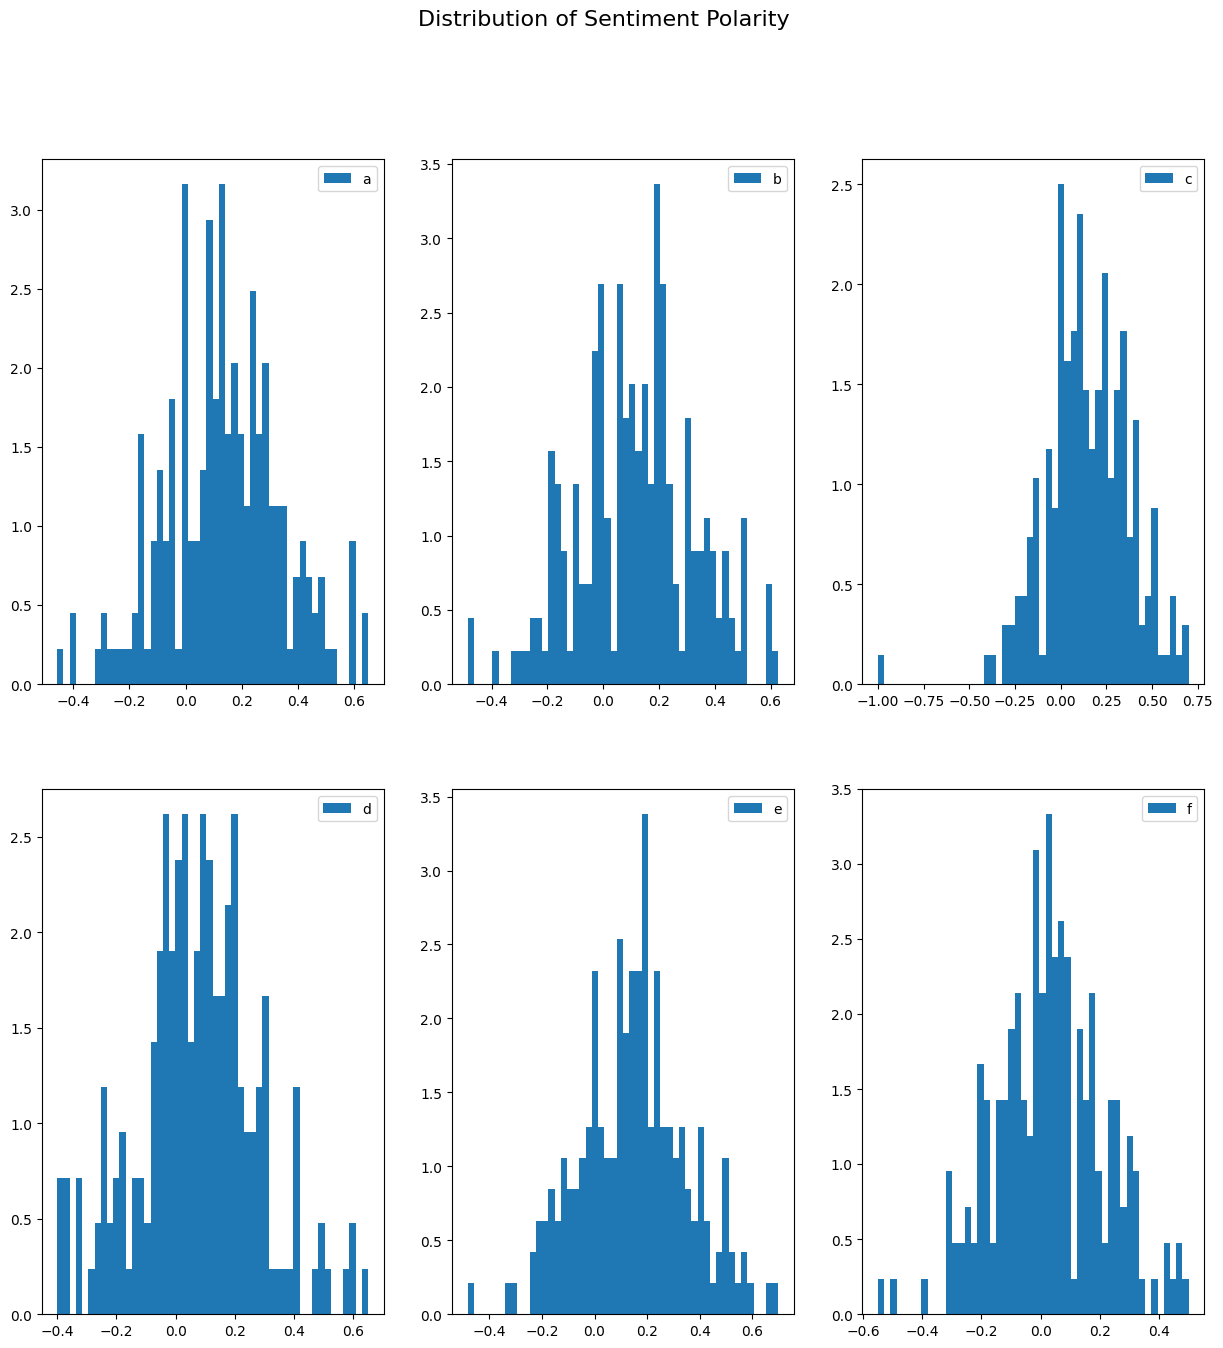

In [82]:
# Evaluation of Sentiment Polarity Feature using histograms:
# Distribution of Sentiment Polarity
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))  # Adjust the width and height as needed
fig.suptitle('Distribution of Sentiment Polarity', fontsize=16)
for i in range(2):
  for j in range(3):
    axes[i,j].hist(data[data['Label']==Labels[np.ravel_multi_index((i,j), (2,3))]]['Sentiment_polarity'], bins=50, density=True, label= Labels[np.ravel_multi_index((i,j), (2,3))]) # alpha tells how dark the shade of the histogram must be, normed= True to normalize our plots to the same scale because there is a lot more ham than spam
    axes[i,j].legend(loc='upper right')
plt.show()

In [83]:
# New feature: Sentiment Subjectivity
data['Sentiment_subjectivity']= data['Partition_lemmatized'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
data

,Book Title,Book Author,Label,Partition,Partition_stemmed,Partition_lemmatized,Word_count,Character_count,Sentence_count,Avg_word_length,Avg_sentence_length,Sentiment_polarity,Sentiment_subjectivity
0,The Alchemist,Ben Jonson,a,"about it Of silver , should have run with crea...",silver run cream hogsden everi sunday moorfiel...,silver run cream hogsden every sunday moorfiel...,40,193,5,4.825000,8.000000,0.000000,0.000000
1,The Alchemist,Ben Jonson,a,"piece of money , many coins being stamped with...",piec money mani coin stamp cross cross pile he...,piece money many coin stamped cross cross pile...,45,271,11,6.022222,4.090909,0.085714,0.157143
2,The Alchemist,Ben Jonson,a,"Why Dol 's employ 'd , you know . SUB . That '...",dol employ know sub true fore heaven know must...,dol employ know sub true fore heaven know must...,34,163,13,4.794118,2.615385,0.075694,0.503472
3,The Alchemist,Ben Jonson,a,graces pass the hours ? I see You are lodged h...,grace pass hour see lodg hous rare man excel a...,grace pas hour see lodged house rare man excel...,36,191,6,5.305556,6.000000,0.336111,0.800000
4,The Alchemist,Ben Jonson,a,cream does look like opals ; and with these De...,cream look like opal delic meat set high pleas...,cream look like opal delicate meat set high pl...,45,229,5,5.088889,9.000000,0.212000,0.728000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,Crime and Punishment,Fyodor Dostoyevsky,f,man on what they have against me . Enough .......,man enough tell may know tri manag somehow put...,man enough tell may know try manage somehow pu...,26,135,24,5.192308,1.083333,0.075000,0.556250
1196,Crime and Punishment,Fyodor Dostoyevsky,f,to anticipate contingencies by seeking the fav...,anticip conting seek favour younger gener reli...,anticipate contingency seeking favour younger ...,40,304,5,7.600000,8.000000,-0.024554,0.414732
1197,Crime and Punishment,Fyodor Dostoyevsky,f,the shawl dance at the breaking-up ? ’ ( You m...,shawl danc breakingup must mend tear must take...,shawl dance breakingup must mend tear must tak...,39,235,5,6.025641,7.800000,-0.016667,0.300000
1198,Crime and Punishment,Fyodor Dostoyevsky,f,“ What if ... how could I let him go off alone...,could let go alon may drown ach blunder ran ba...,could let go alone may drown ach blunder ran b...,39,219,12,5.615385,3.250000,0.100000,0.150000


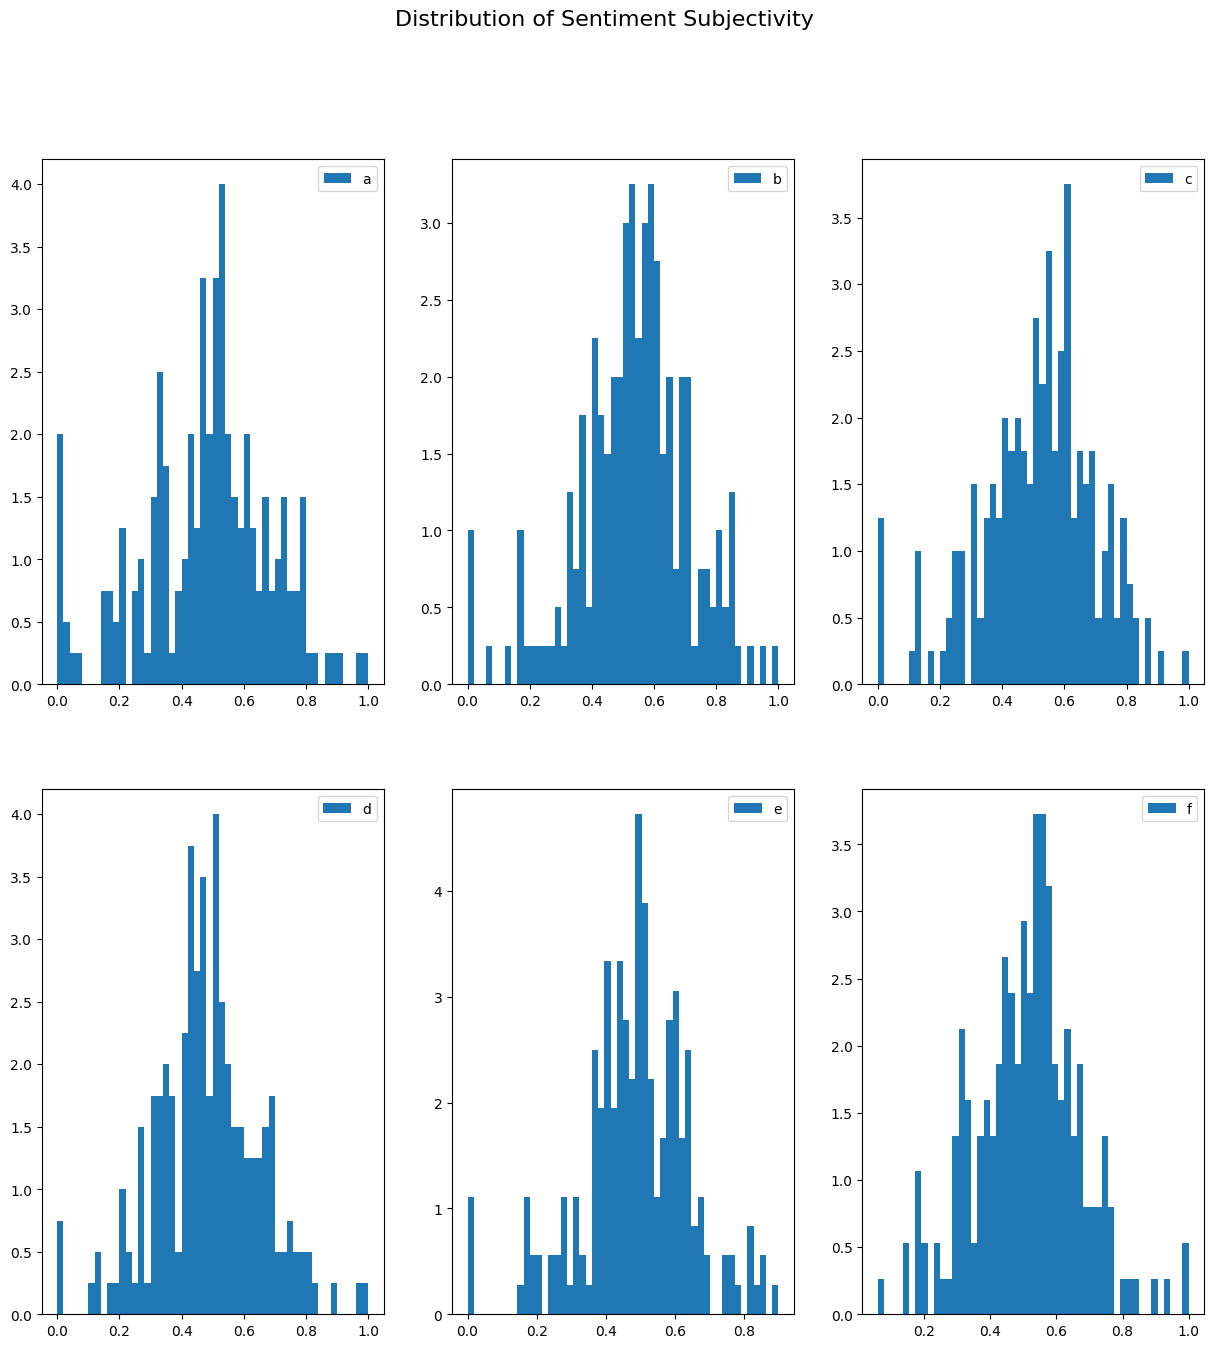

In [84]:
# Evaluation of Sentiment Subjectivity Feature using histograms:
# Distribution of Sentiment Subjectivity
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))  # Adjust the width and height as needed
fig.suptitle('Distribution of Sentiment Subjectivity', fontsize=16)
for i in range(2):
  for j in range(3):
    axes[i,j].hist(data[data['Label']==Labels[np.ravel_multi_index((i,j), (2,3))]]['Sentiment_subjectivity'], bins=50, density=True, label= Labels[np.ravel_multi_index((i,j), (2,3))]) # alpha tells how dark the shade of the histogram must be, normed= True to normalize our plots to the same scale because there is a lot more ham than spam
    axes[i,j].legend(loc='upper right')
plt.show()

## **Most Frequent Words in each book**

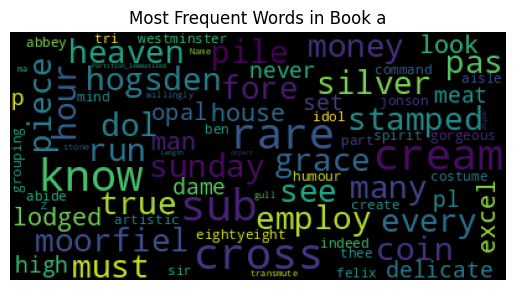

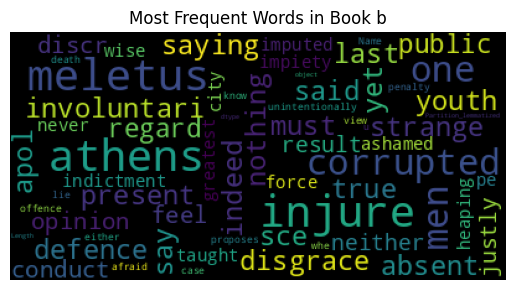

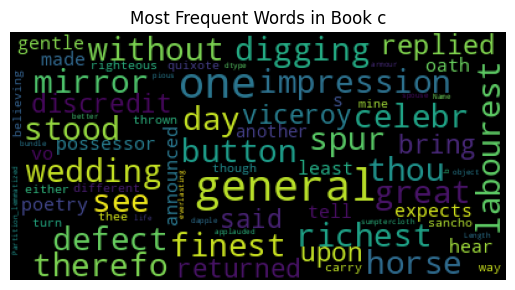

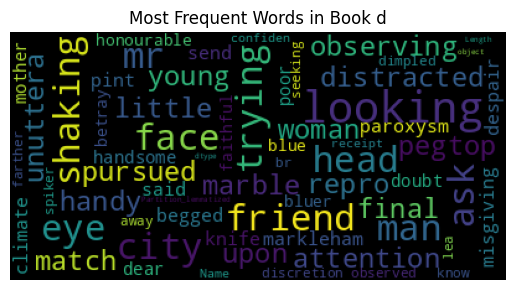

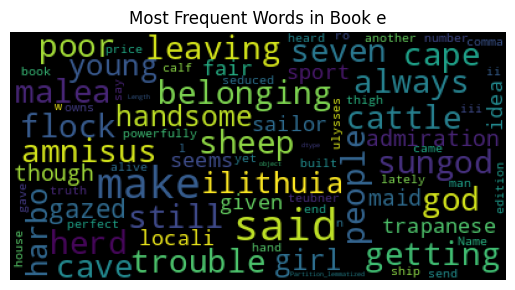

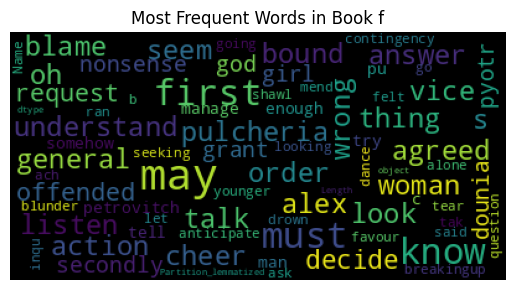

In [85]:
# Most frequent words in each book
for y in data['Label'].unique():
  corpus = data[data['Label']==y]['Partition_lemmatized']
  wc = wordcloud.WordCloud(background_color='black', max_words=100, max_font_size=35)
  wc = wc.generate(str(corpus))
  fig = plt.figure(num=1)
  plt.axis('off')
  plt.title('Most Frequent Words in Book {}'.format(y))
  plt.imshow(wc, cmap=None)
  plt.show()

## **Most Frequent Unigrams and Bigrams in each book**

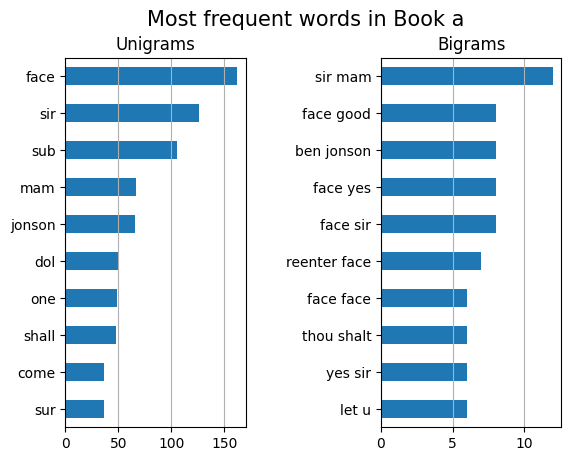

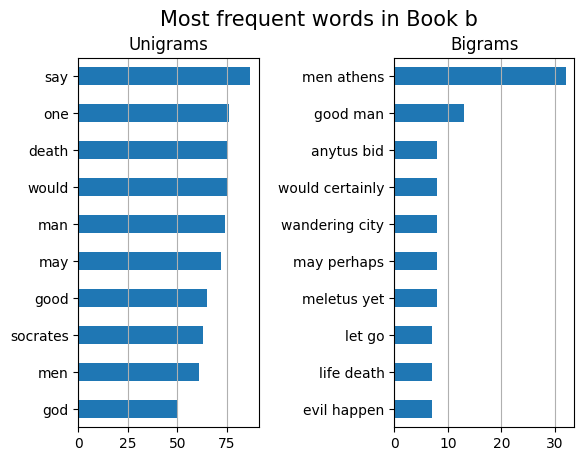

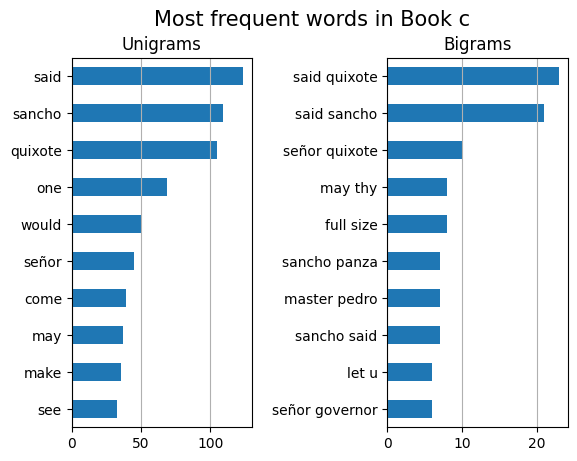

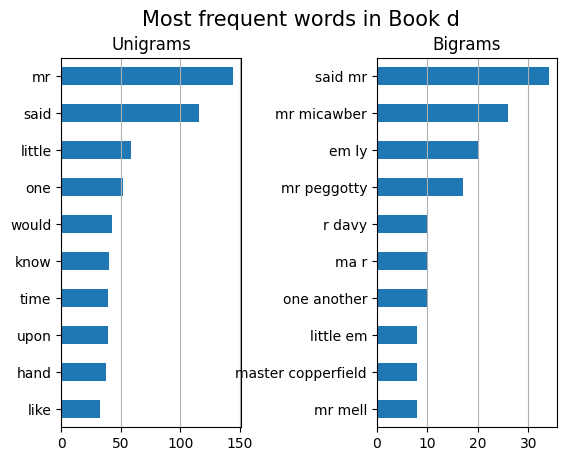

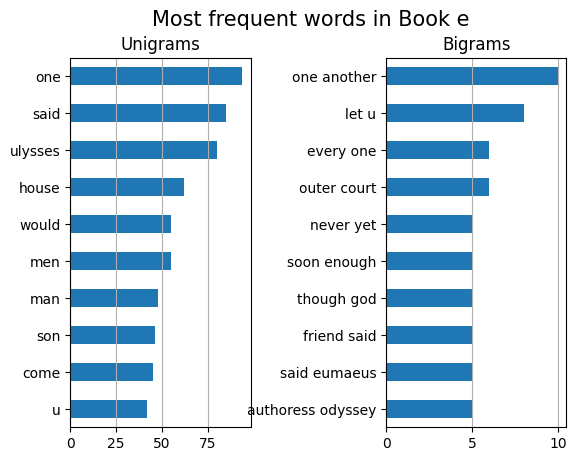

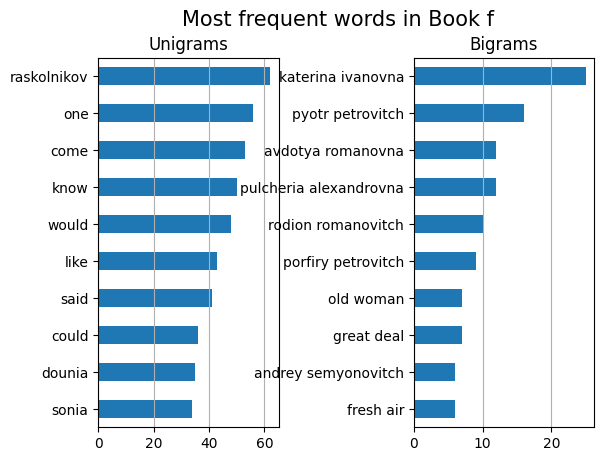

In [86]:
top= 10
for y in data['Label'].unique():
  corpus = data[data['Label']==y]['Partition_lemmatized']
  lst_tokens = get_tokens(corpus.str.cat(sep=" "))
  fig, ax = plt.subplots(nrows=1, ncols=2)
  fig.suptitle("Most frequent words in Book {}".format(y), fontsize=15)
  ## unigrams
  dic_words_freq = nltk.FreqDist(lst_tokens)
  dtf_uni = pd.DataFrame(dic_words_freq.most_common(),columns=["Word","Freq"])
  dtf_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(kind="barh", title="Unigrams", ax=ax[0],legend=False).grid(axis='x')
  ax[0].set(ylabel=None)
  ## bigrams
  dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
  dtf_bi = pd.DataFrame(dic_words_freq.most_common(),columns=["Word","Freq"])
  dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(string for string in x) )
  dtf_bi.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(kind="barh", title="Bigrams", ax=ax[1],legend=False).grid(axis='x')
  ax[1].set(ylabel=None)
  plt.subplots_adjust(wspace=0.75)
  plt.show()

# **Feature Engineering: Transform the data**

Check for distributions that are skewed i.e. having a tail extending out with some outliers. A model might dig too much into this skewed tail and generate a model maybe that's a little bit biased, so it's important to transform features with such distributions.

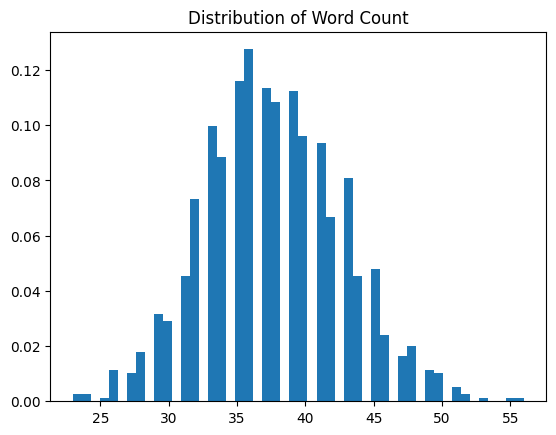

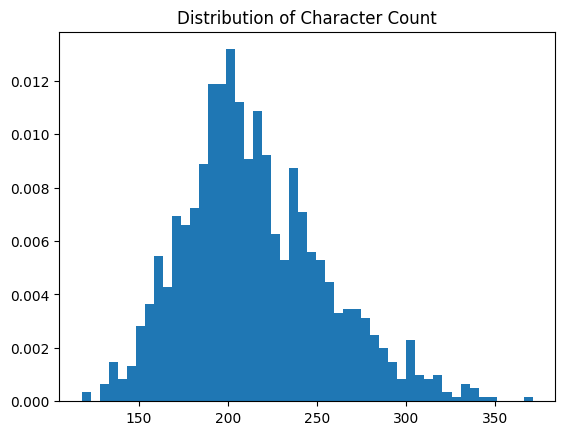

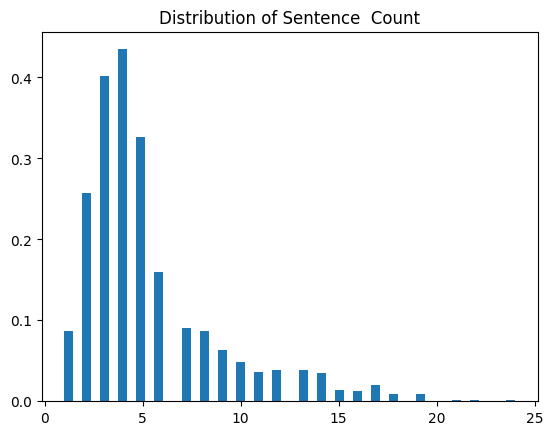

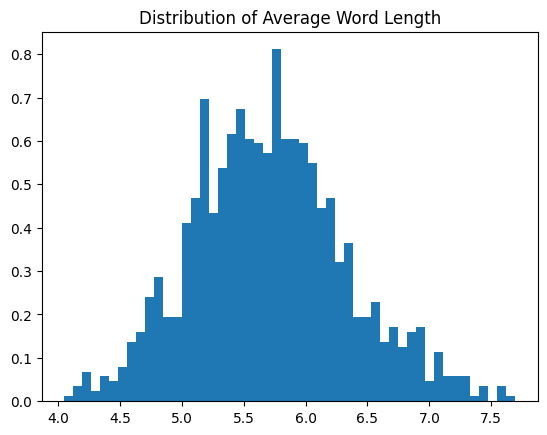

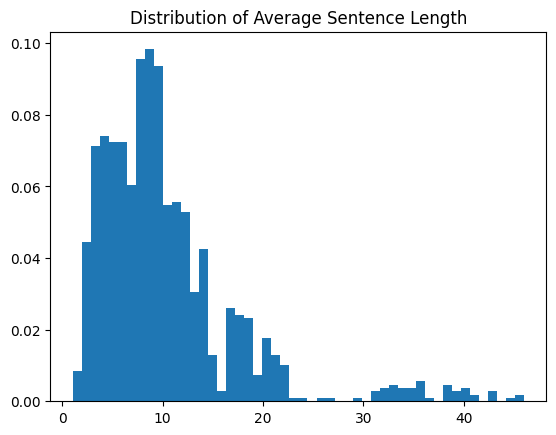

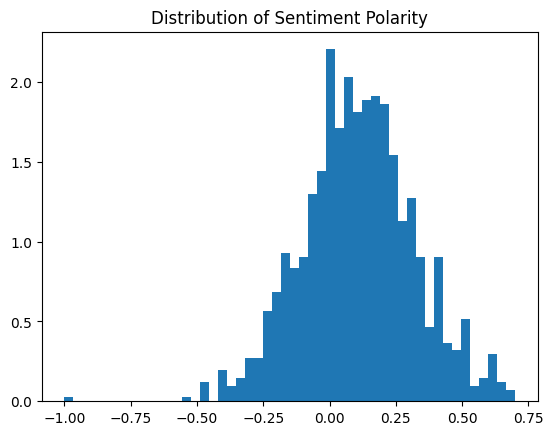

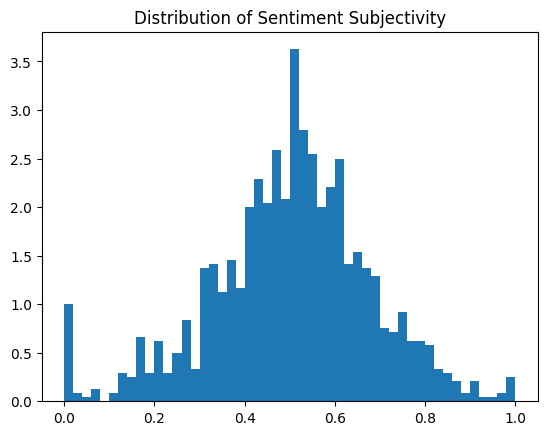

In [87]:
# Distribution of Word Count
plt.title('Distribution of Word Count')
plt.hist(data['Word_count'], bins=50, density=True)
plt.show()

# Distribution of Character Count
plt.title('Distribution of Character Count')
plt.hist(data['Character_count'], bins=50, density=True)
plt.show()

# Distribution of Sentence Count
plt.title('Distribution of Sentence  Count')
plt.hist(data['Sentence_count'], bins=50, density=True)
plt.show()

# Distribution of Average Word Length
plt.title('Distribution of Average Word Length')
plt.hist(data['Avg_word_length'], bins=50, density=True)
plt.show()

# Distribution of Average Sentence Length
plt.title('Distribution of Average Sentence Length')
plt.hist(data['Avg_sentence_length'], bins=50, density=True)
plt.show()

# Distribution of sentiment polarity
plt.title('Distribution of Sentiment Polarity')
plt.hist(data['Sentiment_polarity'], bins=50, density=True)
plt.show()

# Distribution of sentiment subjectivity
plt.title('Distribution of Sentiment Subjectivity')
plt.hist(data['Sentiment_subjectivity'], bins=50, density=True)
plt.show()

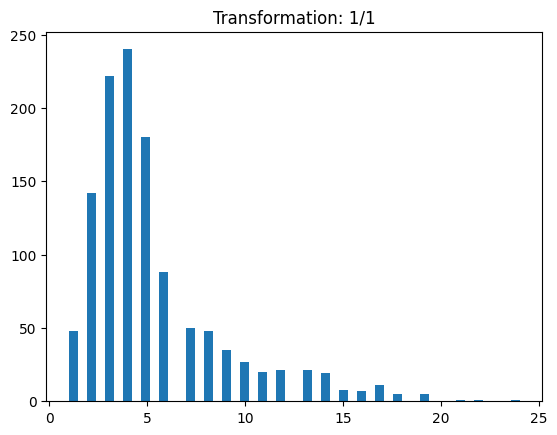

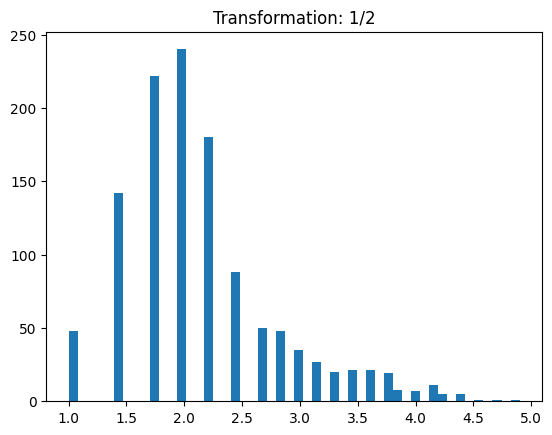

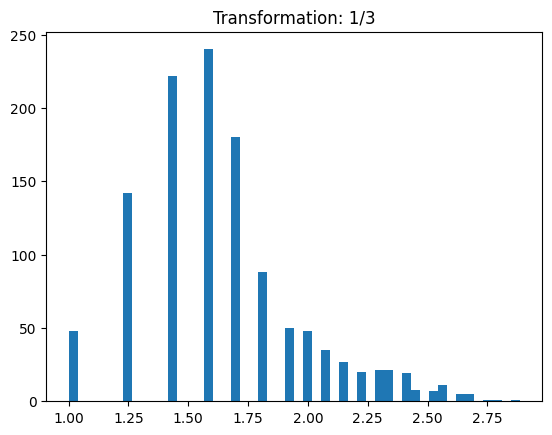

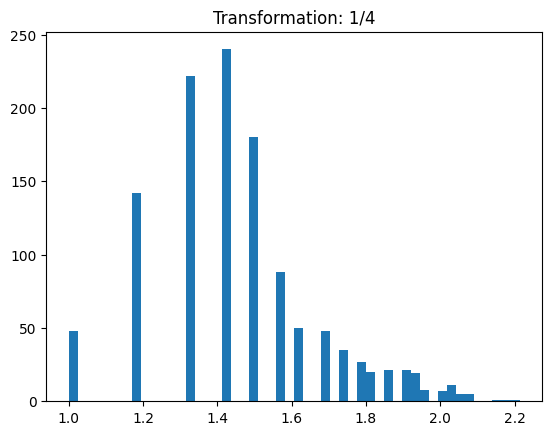

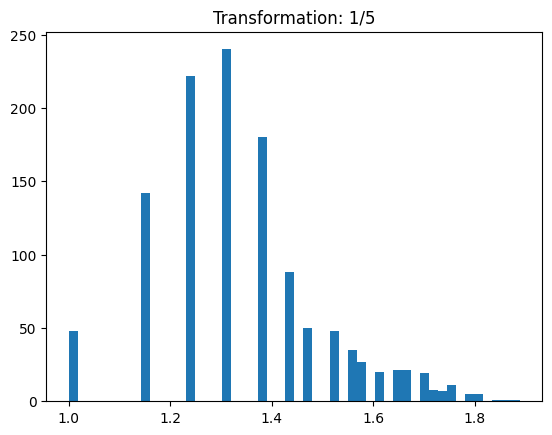

In [88]:
# Box-Cox Power Transformation of Sentence Count
# First we determine what range of exponents we want to test out. So in our example we had a range from negative two to positive two. And that's a commonly used range. Then we'll apply these transformations to each value in the feature we like to transform. Then we will use some criteria to determine which of the transformations yielded the best distribution. We can find different criteria to use to determine the best distribution, but today, we're just going to plot it in a histogram and pick the one that looks the most like a normal distribution because this means it'll be a nice and compact distribution that'll be easier for the model to use.
for i in [1,2,3,4,5]:
   # [] is list of exponents
   plt.hist((data['Sentence_count'])**(1/i), bins=50) # we actually want exponent 1/i here and not i
   plt.title('Transformation: 1/{}'.format(i))
   plt.show()

In [89]:
data['Sentence_count']= data['Sentence_count']**(1/5)

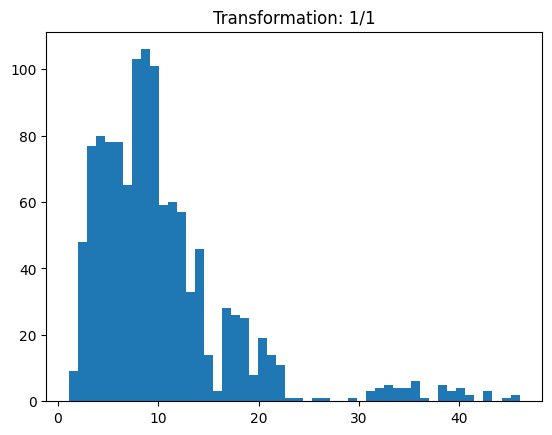

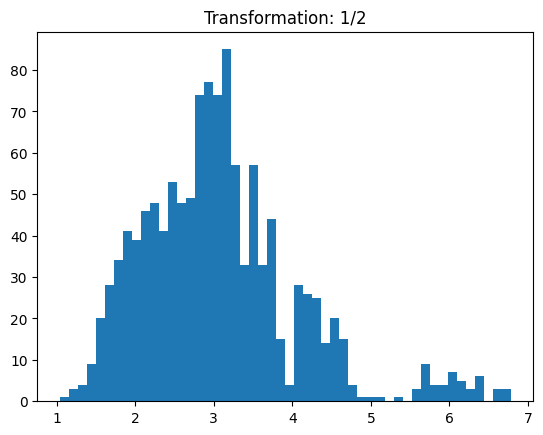

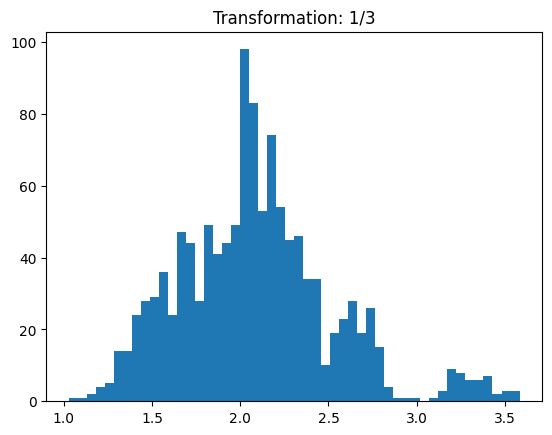

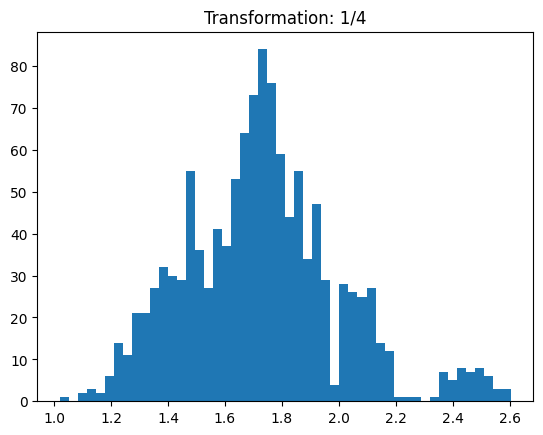

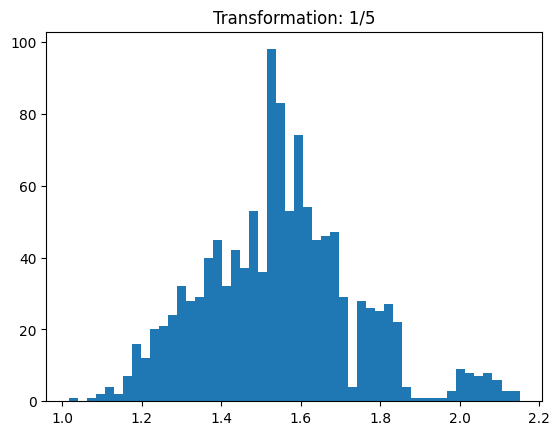

In [90]:
# Box-Cox Power Transformation of Average Sentence Length
# First we determine what range of exponents we want to test out. So in our example we had a range from negative two to positive two. And that's a commonly used range. Then we'll apply these transformations to each value in the feature we like to transform. Then we will use some criteria to determine which of the transformations yielded the best distribution. We can find different criteria to use to determine the best distribution, but today, we're just going to plot it in a histogram and pick the one that looks the most like a normal distribution because this means it'll be a nice and compact distribution that'll be easier for the model to use.
for i in [1,2,3,4,5]:
   # [] is list of exponents
   plt.hist((data['Avg_sentence_length'])**(1/i), bins=50) # we actually want exponent 1/i here and not i
   plt.title('Transformation: 1/{}'.format(i))
   plt.show()

In [91]:
data['Avg_sentence_length']= data['Avg_sentence_length']**(1/5)

In [92]:
data

,Book Title,Book Author,Label,Partition,Partition_stemmed,Partition_lemmatized,Word_count,Character_count,Sentence_count,Avg_word_length,Avg_sentence_length,Sentiment_polarity,Sentiment_subjectivity
0,The Alchemist,Ben Jonson,a,"about it Of silver , should have run with crea...",silver run cream hogsden everi sunday moorfiel...,silver run cream hogsden every sunday moorfiel...,40,193,1.379730,4.825000,1.515717,0.000000,0.000000
1,The Alchemist,Ben Jonson,a,"piece of money , many coins being stamped with...",piec money mani coin stamp cross cross pile he...,piece money many coin stamped cross cross pile...,45,271,1.615394,6.022222,1.325452,0.085714,0.157143
2,The Alchemist,Ben Jonson,a,"Why Dol 's employ 'd , you know . SUB . That '...",dol employ know sub true fore heaven know must...,dol employ know sub true fore heaven know must...,34,163,1.670278,4.794118,1.212013,0.075694,0.503472
3,The Alchemist,Ben Jonson,a,graces pass the hours ? I see You are lodged h...,grace pass hour see lodg hous rare man excel a...,grace pas hour see lodged house rare man excel...,36,191,1.430969,5.305556,1.430969,0.336111,0.800000
4,The Alchemist,Ben Jonson,a,cream does look like opals ; and with these De...,cream look like opal delic meat set high pleas...,cream look like opal delicate meat set high pl...,45,229,1.379730,5.088889,1.551846,0.212000,0.728000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,Crime and Punishment,Fyodor Dostoyevsky,f,man on what they have against me . Enough .......,man enough tell may know tri manag somehow put...,man enough tell may know try manage somehow pu...,26,135,1.888175,5.192308,1.016137,0.075000,0.556250
1196,Crime and Punishment,Fyodor Dostoyevsky,f,to anticipate contingencies by seeking the fav...,anticip conting seek favour younger gener reli...,anticipate contingency seeking favour younger ...,40,304,1.379730,7.600000,1.515717,-0.024554,0.414732
1197,Crime and Punishment,Fyodor Dostoyevsky,f,the shawl dance at the breaking-up ? ’ ( You m...,shawl danc breakingup must mend tear must take...,shawl dance breakingup must mend tear must tak...,39,235,1.379730,6.025641,1.508061,-0.016667,0.300000
1198,Crime and Punishment,Fyodor Dostoyevsky,f,“ What if ... how could I let him go off alone...,could let go alon may drown ach blunder ran ba...,could let go alone may drown ach blunder ran b...,39,219,1.643752,5.615385,1.265834,0.100000,0.150000


# **Shuffling data and splitting into training and testing**

In [93]:
#pd.concat([data['Partition_lemmatized'],data['Word_count'],data['Character_count'],data['Sentence_count'],data['Avg_word_length'],data['Avg_sentence_length'],data['Sentiment_polarity'],data['Sentiment_subjectivity']],axis=1)

In [94]:
X_train, X_test, y_train, y_test= train_test_split(data['Partition_lemmatized'],data['Label'], test_size= 0.2, shuffle= True,random_state=42)

In [95]:
X_train.to_csv('X_train.csv', index=False, header=True, encoding= 'utf-8-sig')
X_test.to_csv('X_test.csv', index=False, header=True, encoding= 'utf-8-sig')
y_train.to_csv('y_train.csv', index=False, header=True, encoding= 'utf-8-sig')
y_test.to_csv('y_test.csv', index=False, header=True, encoding= 'utf-8-sig')

In [96]:
X_train= pd.read_csv('X_train.csv', encoding= 'utf-8-sig')
X_test= pd.read_csv('X_test.csv', encoding= 'utf-8-sig')
y_train= pd.read_csv('y_train.csv', encoding= 'utf-8-sig')
y_test= pd.read_csv('y_test.csv', encoding= 'utf-8-sig')

# **Feature Engineering: Vectorization**

## **BOW/Count Vectorization**

In [97]:
# Instantiate CountVectorizer object and define parameters
BOW_vect= CountVectorizer()

# Fit CountVectorizer it to our text corpus ie train the vectorizer object to learn what words are in the corpus and then use it to vectorize our data ie transform our data into feature vectors
BOW_vect.fit(X_train['Partition_lemmatized'])
X_train_BOW= BOW_vect.transform(X_train['Partition_lemmatized'])
X_test_BOW= BOW_vect.transform(X_test['Partition_lemmatized'])

# Expand the sparse matrix to a collection of arrays and store collection of arrays into a data frame
X_train_BOW= pd.DataFrame(X_train_BOW.toarray())
X_test_BOW= pd.DataFrame(X_test_BOW.toarray())
X_train_BOW.columns= BOW_vect.get_feature_names_out()
X_test_BOW.columns= BOW_vect.get_feature_names_out()

In [98]:
# Words that BOW_vect learnt
BOW_vect.vocabulary_

{'would': 7933,
 'fiercer': 2784,
 'inconsiderate': 3759,
 'word': 7911,
 'emancipated': 2369,
 'control': 1532,
 'remark': 5884,
 'must': 4761,
 'understood': 7465,
 'applying': 403,
 'degree': 1878,
 'certainty': 1135,
 'platonic': 5354,
 'socrates': 6604,
 'although': 284,
 'similar': 6489,
 'may': 4520,
 'spoken': 6725,
 'exclude': 2580,
 'possibility': 5447,
 'like': 4275,
 'much': 4738,
 'else': 2365,
 'eg': 2329,
 'wisdom': 7876,
 'critias': 1694,
 'poem': 5397,
 'solon': 6619,
 'virtue': 7658,
 'charmides': 1164,
 'due': 2255,
 'imagination': 3683,
 'plato': 5353,
 'argument': 445,
 'maintain': 4433,
 'flesh': 2855,
 'let': 4240,
 'half': 3352,
 'wager': 7687,
 'spent': 6703,
 'wine': 7868,
 'take': 7064,
 'gentleman': 3129,
 'tavern': 7090,
 'best': 764,
 'cloak': 1284,
 'rain': 5720,
 'thank': 7143,
 'sir': 6511,
 'said': 6142,
 'quixote': 5706,
 'stop': 6842,
 'instant': 3852,
 'sad': 6133,
 'thought': 7196,
 'unhappy': 7486,
 'circumstance': 1242,
 'force': 2921,
 'seem': 6

## **N-grams Vectorization**

In [99]:
# Instantiate CountVectorizer object and define parameters
ngram_vect= CountVectorizer(ngram_range=(1,2))

# Fit CountVectorizer it to our text corpus ie train the vectorizer object to learn what words are in the corpus and then use it to vectorize our data ie transform our data into feature vectors
ngram_vect.fit(X_train['Partition_lemmatized'])
X_train_ngram= ngram_vect.transform(X_train['Partition_lemmatized'])
X_test_ngram= ngram_vect.transform(X_test['Partition_lemmatized'])

# Expand the sparse matrix to a collection of arrays and store collection of arrays into a data frame
X_train_ngram= pd.DataFrame(X_train_ngram.toarray())
X_test_ngram= pd.DataFrame(X_test_ngram.toarray())
X_train_ngram.columns= ngram_vect.get_feature_names_out()
X_test_ngram.columns= ngram_vect.get_feature_names_out()

In [100]:
# Words that ngram_vect learnt
ngram_vect.vocabulary_

{'would': 37426,
 'fiercer': 11505,
 'inconsiderate': 16059,
 'word': 37190,
 'emancipated': 9568,
 'control': 6273,
 'remark': 26761,
 'must': 21639,
 'understood': 35070,
 'applying': 1684,
 'degree': 7753,
 'certainty': 4786,
 'platonic': 24570,
 'socrates': 30380,
 'although': 1042,
 'similar': 29851,
 'may': 20232,
 'spoken': 31083,
 'exclude': 10461,
 'possibility': 24957,
 'like': 18458,
 'much': 21487,
 'else': 9535,
 'eg': 9409,
 'wisdom': 36909,
 'critias': 6945,
 'poem': 24728,
 'solon': 30455,
 'virtue': 35740,
 'charmides': 4934,
 'due': 9126,
 'imagination': 15852,
 'plato': 24559,
 'argument': 1781,
 'maintain': 19566,
 'would fiercer': 37476,
 'fiercer inconsiderate': 11506,
 'inconsiderate word': 16060,
 'word emancipated': 37206,
 'emancipated control': 9569,
 'control remark': 6276,
 'remark must': 26764,
 'must understood': 21725,
 'understood applying': 35071,
 'applying degree': 1685,
 'degree certainty': 7755,
 'certainty platonic': 4789,
 'platonic socrates': 24

## **TF-IDF Vectorization**

In [101]:
# Instantiate TfidfVectorizer object and define parameters
tfidf_vect= TfidfVectorizer()

# Fit TfidfVectorizer it to our text corpus ie train the vectorizer object to learn what words are in the corpus and then use it to vectorize our data ie transform our data into feature vectors
tfidf_vect.fit(X_train['Partition_lemmatized'])
X_train_tfidf= tfidf_vect.transform(X_train['Partition_lemmatized'])
X_test_tfidf= tfidf_vect.transform(X_test['Partition_lemmatized'])

# Expand the sparse matrix to a collection of arrays and store collection of arrays to a data frame
X_train_tfidf= pd.DataFrame(X_train_tfidf.toarray())
X_test_tfidf= pd.DataFrame(X_test_tfidf.toarray())
X_train_tfidf.columns= tfidf_vect.get_feature_names_out()
X_test_tfidf.columns= tfidf_vect.get_feature_names_out()

In [102]:
# Words that tfidf_vect learnt
tfidf_vect.vocabulary_

{'would': 7933,
 'fiercer': 2784,
 'inconsiderate': 3759,
 'word': 7911,
 'emancipated': 2369,
 'control': 1532,
 'remark': 5884,
 'must': 4761,
 'understood': 7465,
 'applying': 403,
 'degree': 1878,
 'certainty': 1135,
 'platonic': 5354,
 'socrates': 6604,
 'although': 284,
 'similar': 6489,
 'may': 4520,
 'spoken': 6725,
 'exclude': 2580,
 'possibility': 5447,
 'like': 4275,
 'much': 4738,
 'else': 2365,
 'eg': 2329,
 'wisdom': 7876,
 'critias': 1694,
 'poem': 5397,
 'solon': 6619,
 'virtue': 7658,
 'charmides': 1164,
 'due': 2255,
 'imagination': 3683,
 'plato': 5353,
 'argument': 445,
 'maintain': 4433,
 'flesh': 2855,
 'let': 4240,
 'half': 3352,
 'wager': 7687,
 'spent': 6703,
 'wine': 7868,
 'take': 7064,
 'gentleman': 3129,
 'tavern': 7090,
 'best': 764,
 'cloak': 1284,
 'rain': 5720,
 'thank': 7143,
 'sir': 6511,
 'said': 6142,
 'quixote': 5706,
 'stop': 6842,
 'instant': 3852,
 'sad': 6133,
 'thought': 7196,
 'unhappy': 7486,
 'circumstance': 1242,
 'force': 2921,
 'seem': 6

## **word2vec Vectorization**

In [103]:
# Fit Word2Vec Model to create vectors of length 100 for any word that apppears at least twice in the training set by using a window of 5 words before after the keyword to understand in which context the word is used
w2v_vect= gensim.models.Word2Vec(X_train['Partition_lemmatized'].apply(lambda x: get_tokens(x)),vector_size=100,window=5,min_count=2)

In [104]:
# Words that w2v_vect learnt
w2v_vect.wv.index_to_key

['one',
 'said',
 'would',
 'face',
 'come',
 'man',
 'say',
 'may',
 'know',
 'good',
 'like',
 'time',
 'mr',
 'see',
 'make',
 'upon',
 'sir',
 'must',
 'shall',
 'made',
 'hand',
 'men',
 'take',
 'could',
 'u',
 'god',
 'way',
 'well',
 'go',
 'word',
 'house',
 'life',
 'even',
 'little',
 'sancho',
 'thing',
 'tell',
 'sub',
 'never',
 'went',
 'another',
 'much',
 'great',
 'day',
 'two',
 'quixote',
 'might',
 'let',
 'came',
 'back',
 'nothing',
 'death',
 'give',
 'though',
 'many',
 'son',
 'first',
 'look',
 'eye',
 'think',
 'old',
 'away',
 'ulysses',
 'better',
 'put',
 'head',
 'told',
 'yet',
 'long',
 'still',
 'home',
 'friend',
 'going',
 'saw',
 'mind',
 'thou',
 'whether',
 'thought',
 'woman',
 'mother',
 'set',
 'socrates',
 'get',
 'without',
 'believe',
 'every',
 'something',
 'person',
 'last',
 'people',
 'raskolnikov',
 'always',
 'took',
 'young',
 'speak',
 'night',
 'found',
 'yes',
 'three',
 'jonson',
 'asked',
 'poor',
 'left',
 'love',
 'also',
 'c

In [105]:
#Take each partition which is just a list of words now and replace each word in this partition with its word vector from word2vec model then average the word vectors for each partition to get the vector of the partition
words= set(w2v_vect.wv.index_to_key)
X_train_w2v= pd.DataFrame(np.zeros((len(X_train),100)))
for i,ls in  enumerate(X_train['Partition_lemmatized'].apply(lambda x: get_tokens(x))):
  S= np.zeros(100,)
  for word in ls:
    if word in words:
      S+= w2v_vect.wv[i]
  X_train_w2v.iloc[i]= S/len(ls)

X_test_w2v= pd.DataFrame(np.zeros((len(X_test),100)))
for i,ls in  enumerate(X_test['Partition_lemmatized'].apply(lambda x: get_tokens(x))):
  S= np.zeros(100,)
  for word in ls:
    if word in words:
      S+= w2v_vect.wv[i]
  X_test_w2v.iloc[i]= S/len(ls)

word2vec is not really intended to create representations of sentences. We're just crudely averaging across word vectors to get a sentence or text level representation, but that loses information.

## **doc2vec Vectorization**

doc2vec requires you to create tagged documents. This tagged document, expects a list of words and a tag for each document. And then the doc2vec model trains on top of those tagged documents. There are numerous ways you can assign the tag. One common way is just to use the index as the tag.


In [106]:
# Create tagged document objects for each partition in the training and test sets
tagged_docs_train= [gensim.models.doc2vec.TaggedDocument(v, [i]) for i,v in enumerate(X_train['Partition_lemmatized'].apply(lambda x: get_tokens(x)))]
tagged_docs_test= [gensim.models.doc2vec.TaggedDocument(v, [i]) for i,v in enumerate(X_test['Partition_lemmatized'].apply(lambda x: get_tokens(x)))]

In [107]:
# Train a basic doc2vec model
d2v_vect= gensim.models.Doc2Vec(tagged_docs_train, vector_size=100, window=5, min_count=2)

In [108]:
# Infer the vectors to be used in training and testing
X_train_d2v= pd.DataFrame(np.array([d2v_vect.infer_vector(v.words) for v in tagged_docs_train]))
X_test_d2v= pd.DataFrame(np.array([d2v_vect.infer_vector(v.words) for v in tagged_docs_test]))

## **A Baseline Performance Evaluation to Choose Top Vectorizers**

We start with Random Forest Classifier as a baseline model to identify the top vectorizers

In [109]:
# Fit a basic RF classifier on BOW Vectorizations
rf= RandomForestClassifier()
rf_BOW= rf.fit(X_train_BOW,y_train.values.ravel())

# Use the trained RF to make predictions on the test data
y_pred_BOW= rf_BOW.predict(X_test_BOW)

# Evaluate the predictions of the model on the holdout test set
accuracy_BOW= accuracy_score(y_test,y_pred_BOW)
precision_BOW= precision_score(y_test,y_pred_BOW,average=None)
recall_BOW= recall_score(y_test,y_pred_BOW,average=None)
print('Using BOW vectorization, the baseline classifier achieved: Accuracy={}, Precision={}, Recall={}'.format(accuracy_BOW,precision_BOW,recall_BOW))

Using BOW vectorization, the baseline classifier achieved: Accuracy=0.8958333333333334, Precision=[0.86363636 0.95833333 1.         0.86111111 0.94871795 0.75609756], Recall=[0.97435897 0.95833333 0.91428571 0.81578947 0.82222222 0.88571429]


In [110]:
# Fit a basic RF classifier on ngram Vectorizations
rf= RandomForestClassifier()
rf_ngram= rf.fit(X_train_ngram,y_train.values.ravel())

# Use the trained RF to make predictions on the test data
y_pred_ngram= rf_ngram.predict(X_test_ngram)

# Evaluate the predictions of the model on the holdout test set
accuracy_ngram= accuracy_score(y_test,y_pred_ngram)
precision_ngram= precision_score(y_test,y_pred_ngram,average=None)
recall_ngram= recall_score(y_test,y_pred_ngram,average=None)
print('Using ngram vectorization, the baseline classifier achieved: Accuracy={}, Precision={}, Recall={}'.format(accuracy_ngram,precision_ngram,recall_ngram))

Using ngram vectorization, the baseline classifier achieved: Accuracy=0.8791666666666667, Precision=[0.80851064 0.9375     0.93939394 0.85294118 0.95       0.78947368], Recall=[0.97435897 0.9375     0.88571429 0.76315789 0.84444444 0.85714286]


In [111]:
# Fit a basic RF classifier on tfidf Vectorizations
rf= RandomForestClassifier()
rf_tfidf= rf.fit(X_train_tfidf,y_train.values.ravel())

# Use the trained RF to make predictions on the test data
y_pred_tfidf= rf_tfidf.predict(X_test_tfidf)

# Evaluate the predictions of the model on the holdout test set
accuracy_tfidf= accuracy_score(y_test,y_pred_tfidf)
precision_tfidf= precision_score(y_test,y_pred_tfidf,average=None)
recall_tfidf= recall_score(y_test,y_pred_tfidf,average=None)
print('Using tfidf vectorization, the baseline classifier achieved: Accuracy={}, Precision={}, Recall={}'.format(accuracy_tfidf,precision_tfidf,recall_tfidf))

Using tfidf vectorization, the baseline classifier achieved: Accuracy=0.8958333333333334, Precision=[0.9047619  0.92156863 0.96969697 0.89473684 0.925      0.75      ], Recall=[0.97435897 0.97916667 0.91428571 0.89473684 0.82222222 0.77142857]


In [112]:
# Fit a basic RF classifier on w2v Vectorizations
rf= RandomForestClassifier()
rf_w2v= rf.fit(X_train_w2v,y_train.values.ravel())

# Use the trained RF to make predictions on the test data
y_pred_w2v= rf_w2v.predict(X_test_w2v)

# Evaluate the predictions of the model on the holdout test set
accuracy_w2v= accuracy_score(y_test,y_pred_w2v)
precision_w2v= precision_score(y_test,y_pred_w2v,average=None)
recall_w2v= recall_score(y_test,y_pred_w2v,average=None)
print('Using w2v vectorization, the baseline classifier achieved: Accuracy={}, Precision={}, Recall={}'.format(accuracy_w2v,precision_w2v,recall_w2v))

Using w2v vectorization, the baseline classifier achieved: Accuracy=0.19583333333333333, Precision=[0.31034483 0.22222222 0.13114754 0.21428571 0.14285714 0.2       ], Recall=[0.23076923 0.20833333 0.22857143 0.23684211 0.08888889 0.2       ]


In [113]:
# Fit a basic RF classifier on d2v Vectorizations
rf= RandomForestClassifier()
rf_d2v= rf.fit(X_train_d2v,y_train.values.ravel())

# Use the trained RF to make predictions on the test data
y_pred_d2v= rf_d2v.predict(X_test_d2v)

# Evaluate the predictions of the model on the holdout test set
accuracy_d2v= accuracy_score(y_test,y_pred_d2v)
precision_d2v= precision_score(y_test,y_pred_d2v,average=None)
recall_d2v= recall_score(y_test,y_pred_d2v,average=None)
print('Using d2v vectorization, the baseline classifier achieved: Accuracy={}, Precision={}, Recall={}'.format(accuracy_d2v,precision_d2v,recall_d2v))

Using d2v vectorization, the baseline classifier achieved: Accuracy=0.32083333333333336, Precision=[0.56666667 0.48648649 0.1875     0.27777778 0.30188679 0.14705882], Recall=[0.43589744 0.375      0.17142857 0.39473684 0.35555556 0.14285714]


The top vectorizers are BOW, Ngrams, and TFIDF since they achieved high testing accuracies (around 90%) when compared to word2vec and doc2vec test accuracies which are below 40%.

# **Train and Evaluate ML Classifiers**

## **Encoding of Classes**

In [114]:
le = LabelEncoder()

y_train_enc = le.fit_transform(y_train.values.ravel())
y_test_enc = le.transform(y_test.values.ravel())

In [115]:
le.classes_

array(['a', 'b', 'c', 'd', 'e', 'f'], dtype=object)

## **ML Classifiers**

1. KNN
2. Multinomial Naive Bias
3. Multinomial Logistic Regression
4. Decision Trees
5. Random Forest

## **Function to do 10-fold Cross Validation for each classifier**

In [116]:
def cross_validation(model,X,y,cv):
  metrics = ['accuracy','precision_macro','recall_macro','f1_macro']
  results= cross_validate(estimator=model,X=X,y=y,cv=cv,scoring=metrics,return_train_score=True,n_jobs=-1)
  return {"Training Accuracy scores": results['train_accuracy'],
          "Mean Training Accuracy": results['train_accuracy'].mean()*100,
          "Training Precision scores": results['train_precision_macro'],
          "Mean Training Precision": results['train_precision_macro'].mean(),
          "Training Recall scores": results['train_recall_macro'],
          "Mean Training Recall": results['train_recall_macro'].mean(),
          "Training F1 scores": results['train_f1_macro'],
          "Mean Training F1 Score": results['train_f1_macro'].mean()*100,
          "Validation Accuracy scores": results['test_accuracy'],
          "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
          "Validation Precision scores": results['test_precision_macro'],
          "Mean Validation Precision": results['test_precision_macro'].mean(),
          "Validation Recall scores": results['test_recall_macro'],
          "Mean Validation Recall": results['test_recall_macro'].mean(),
          "Validation F1 scores": results['test_f1_macro'],
          "Mean Validation F1 Score": results['test_f1_macro'].mean()*100}

## **Function to plot comparisons of the 10-fold cross validations of the 6 classifiers**

In [117]:
def plot_comparison(x_label, y_label, plot_title, val_data1 , val_data2 , val_data3 , val_data4, val_data5):

  plt.figure(figsize=(16,10))
  labels = ["1st Fold", "2nd Fold", "3rd Fold","4th Fold","5th Fold","6th Fold","7th Fold","8th Fold","9th Fold","10th Fold"]
  X_axis = np.arange(len(labels))
  ax = plt.gca()
  plt.ylim(0.40000, 1)
  plt.bar(X_axis-0.2 , val_data1, 0.1, color='red', label='KNN')
  plt.bar(X_axis-0.1 , val_data2, 0.1, color='orange', label='NB')
  plt.bar(X_axis ,  val_data3,  0.1, color='yellow', label='LR')
  plt.bar(X_axis+0.1, val_data4,  0.1, color='green', label='DT')
  plt.bar(X_axis+0.2, val_data5,  0.1, color='blue', label='RF')
  plt.title(plot_title, fontsize=30)
  plt.xticks(X_axis, labels)
  plt.xlabel(x_label, fontsize=14)
  plt.ylabel(y_label, fontsize=14)
  plt.legend(loc="best")
  plt.grid(True)
  plt.show()

## **Function to plot confusion matrix**

In [118]:
def compute_confusion_matrix(y_true,y_pred):
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
  disp.plot()

## **Function to calculate trainning and validation accuracies learning curves**

In [119]:
def plot_learning_curves(model, x, y, cv=10):
    train_sizes, train_scores, test_scores = learning_curve(
        model, x, y, cv=cv, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training Accuracy', marker='o')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15)
    plt.plot(train_sizes, test_mean, label='Validation Accuracy', marker='o')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15)
    plt.xlabel('Number of Training Examples')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## **Classifying BOW Vectorized Data**

### **BOW Vectorization + KNN**

In [120]:
knn= KNeighborsClassifier()
results_BOW_knn= cross_validation(knn,X_train_BOW,y_train_enc,10)

Learning curves of KNN with BOW Vectorized Data


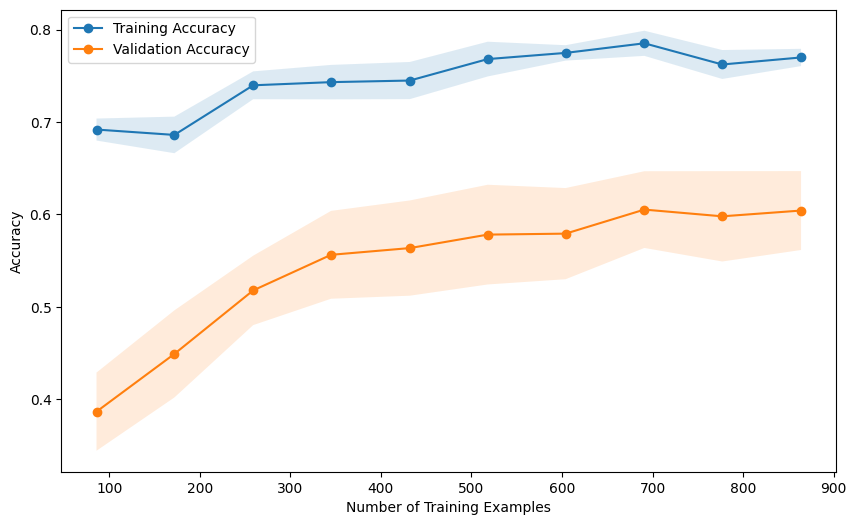

In [121]:
knn= KNeighborsClassifier()
print("Learning curves of KNN with BOW Vectorized Data")
plot_learning_curves(knn,X_train_BOW,y_train_enc)

### **BOW Vectorization + NB**

In [122]:
nb= MultinomialNB(alpha=1.0)
results_BOW_nb= cross_validation(nb,X_train_BOW,y_train_enc,10)

Learning curves of NB with BOW Vectorized Data


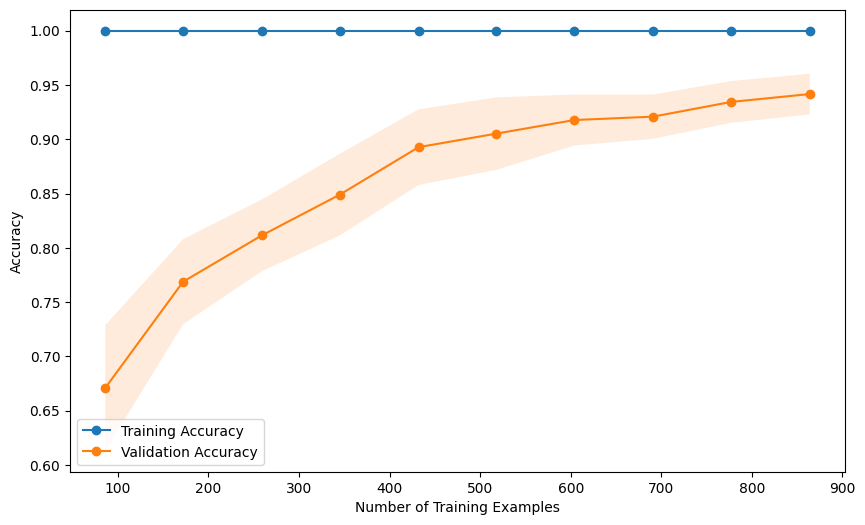

In [123]:
nb= MultinomialNB(alpha=1.0)
print("Learning curves of NB with BOW Vectorized Data")
plot_learning_curves(nb,X_train_BOW,y_train_enc)

### **BOW Vectorization + LR**

In [124]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs',random_state=42)
results_BOW_lr = cross_validation(lr, X_train_BOW,y_train_enc,10)

Learning curves of LR with BOW Vectorized Data


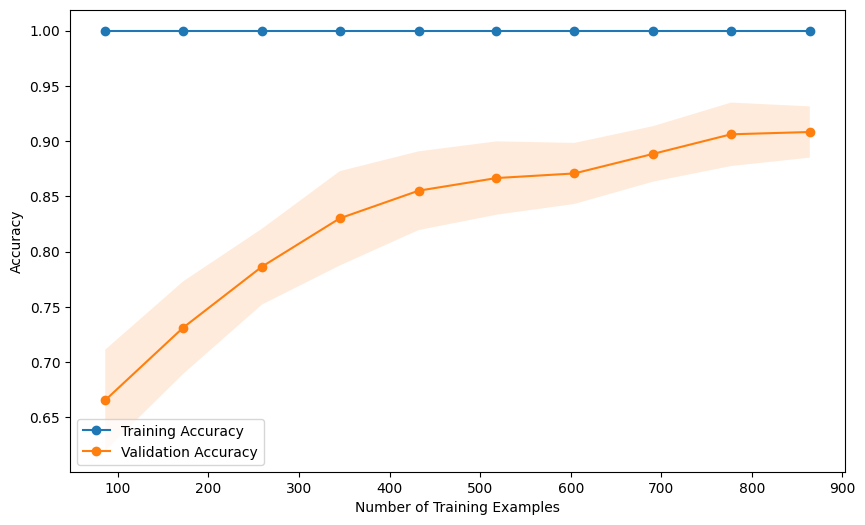

In [125]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs',random_state=42)
print("Learning curves of LR with BOW Vectorized Data")
plot_learning_curves(lr,X_train_BOW,y_train_enc)

### **BOW Vectorization + Decision Tree**

In [126]:
dt= DecisionTreeClassifier(random_state=42)
results_BOW_dt= cross_validation(dt,X_train_BOW,y_train_enc,10)

Learning curves of DT with BOW Vectorized Data


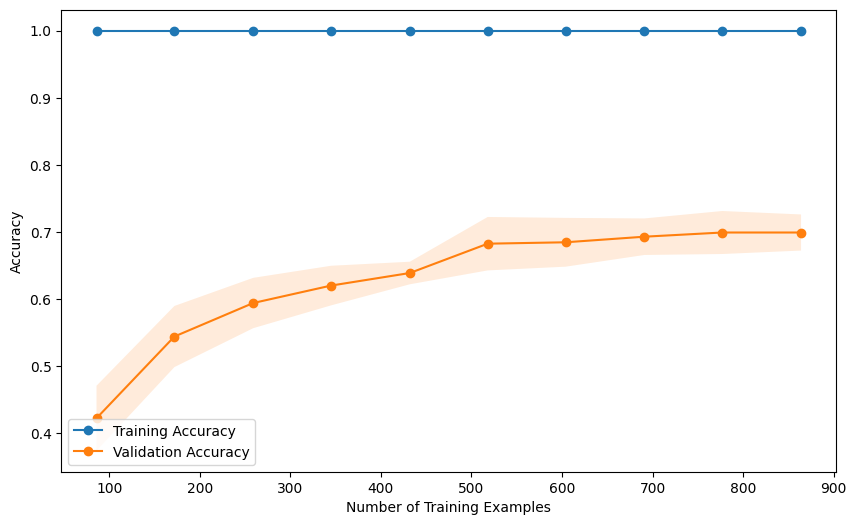

In [127]:
dt= DecisionTreeClassifier(random_state=42)
print("Learning curves of DT with BOW Vectorized Data")
plot_learning_curves(dt,X_train_BOW,y_train_enc)

### **BOW Vectorization + Random Forest**

In [128]:
rf= RandomForestClassifier(random_state=42)
results_BOW_rf= cross_validation(rf,X_train_BOW,y_train_enc,10)

Learning curves of RF with BOW Vectorized Data


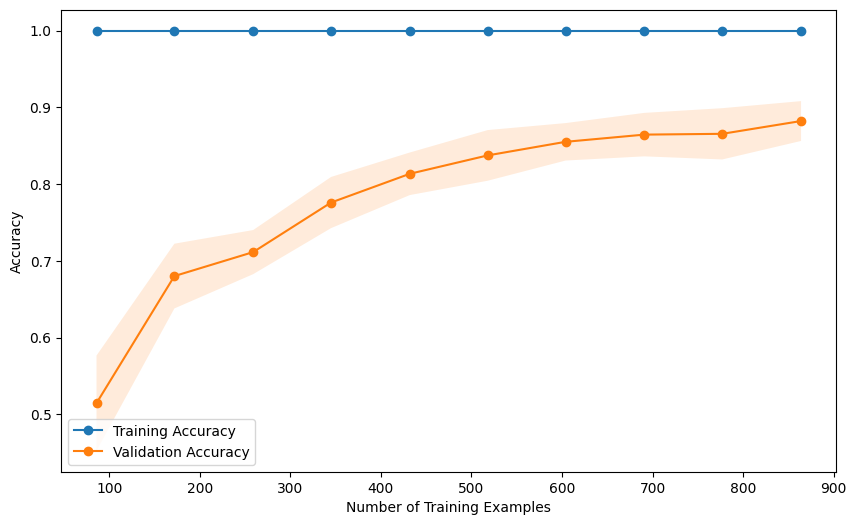

In [129]:
rf= RandomForestClassifier(random_state=42)
print("Learning curves of RF with BOW Vectorized Data")
plot_learning_curves(rf,X_train_BOW,y_train_enc)

### **Testing F1 and Accuracy scores of the 5 classifiers with BOW Vectorization**

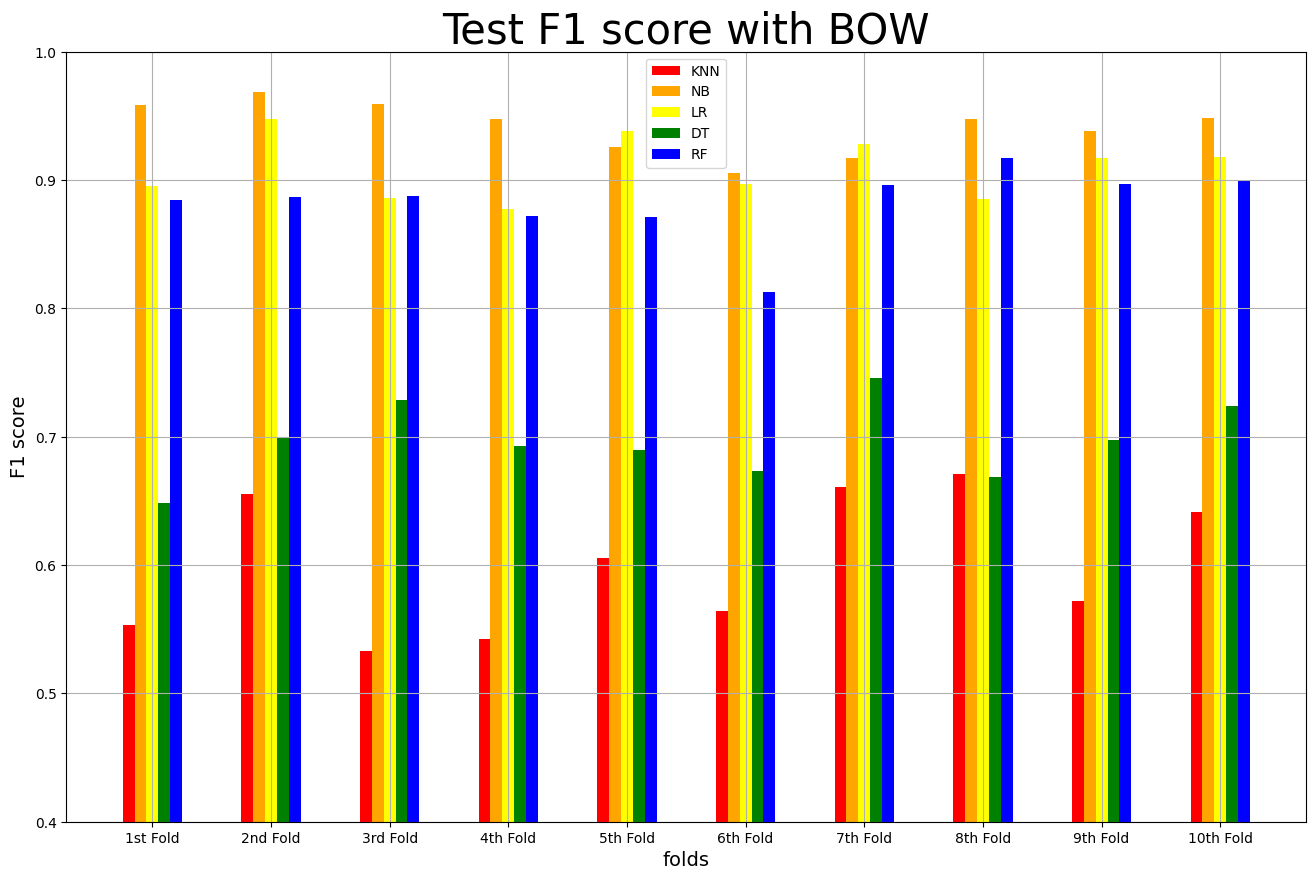

In [130]:
plot_comparison("folds", "F1 score", "Test F1 score with BOW", results_BOW_knn['Validation F1 scores'], results_BOW_nb['Validation F1 scores'], results_BOW_lr['Validation F1 scores'], results_BOW_dt['Validation F1 scores'], results_BOW_rf['Validation F1 scores'])

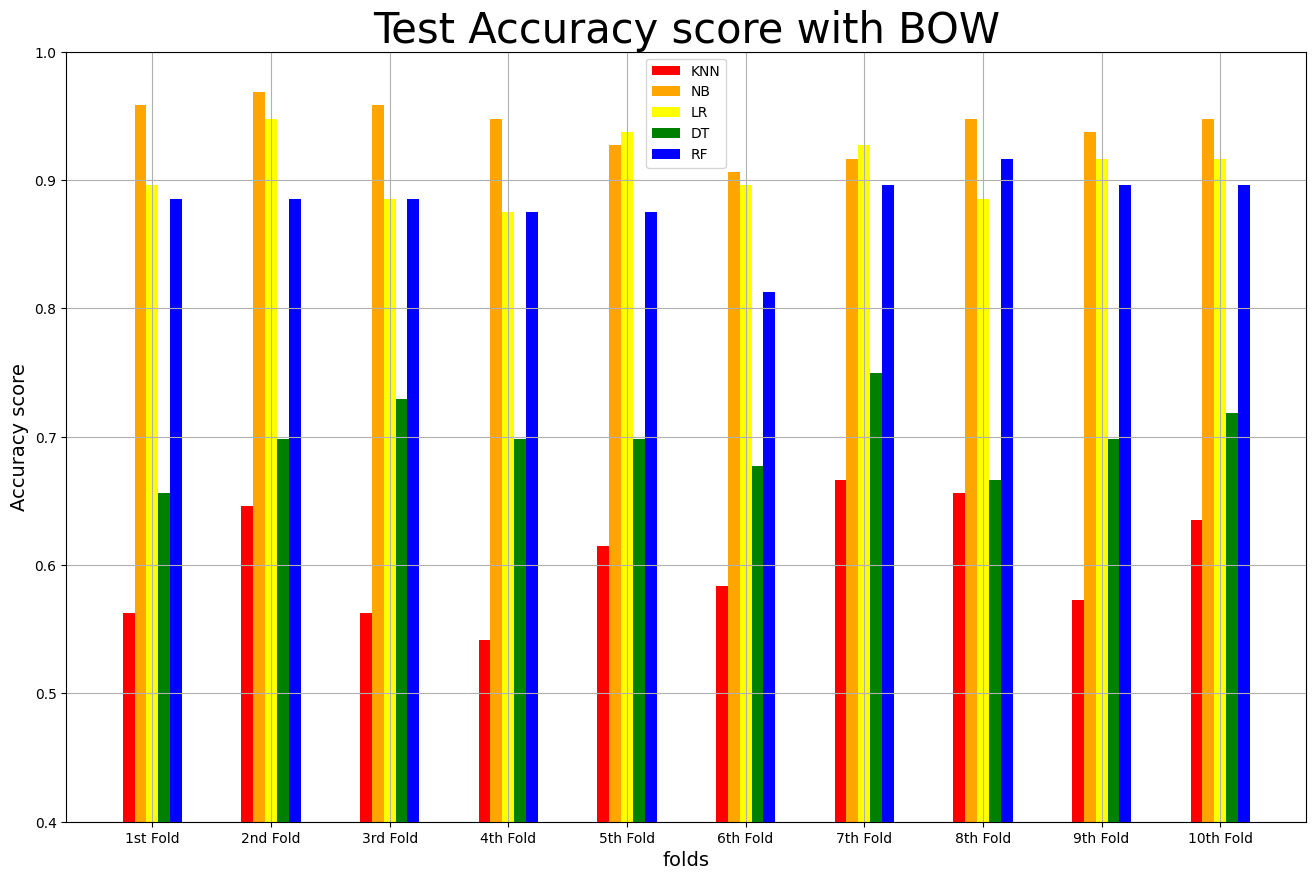

In [131]:
plot_comparison("folds", "Accuracy score", "Test Accuracy score with BOW", results_BOW_knn['Validation Accuracy scores'], results_BOW_nb['Validation Accuracy scores'], results_BOW_lr['Validation Accuracy scores'], results_BOW_dt['Validation Accuracy scores'], results_BOW_rf['Validation Accuracy scores'])

## **Classifying ngram vectorized data**

### **ngram Vectorization + KNN**

In [132]:
knn= KNeighborsClassifier()
results_ngram_knn= cross_validation(knn,X_train_ngram,y_train_enc,10)

Learning curves of KNN with ngram Vectorized Data


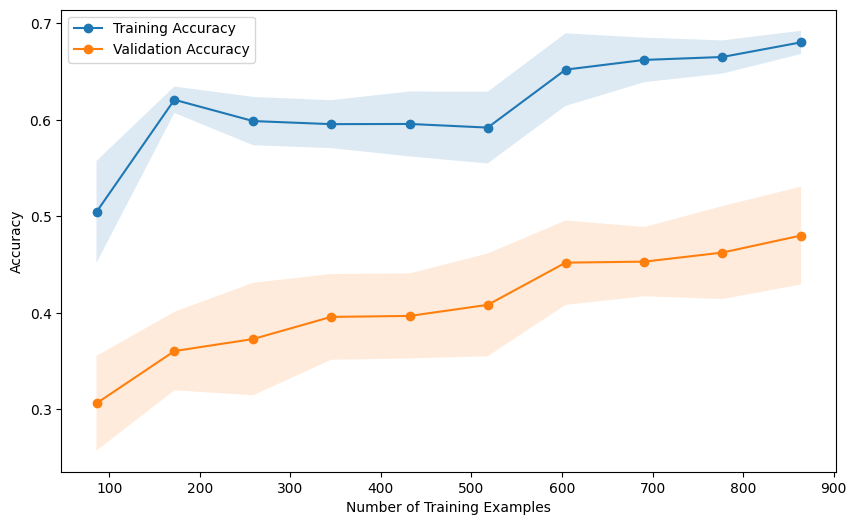

In [133]:
knn= KNeighborsClassifier()
print("Learning curves of KNN with ngram Vectorized Data")
plot_learning_curves(knn,X_train_ngram,y_train_enc)

### **ngram Vectorization + NB**

In [134]:
nb= MultinomialNB(alpha=1.0)
results_ngram_nb= cross_validation(nb,X_train_ngram,y_train_enc,10)

Learning curves of NB with ngram Vectorized Data


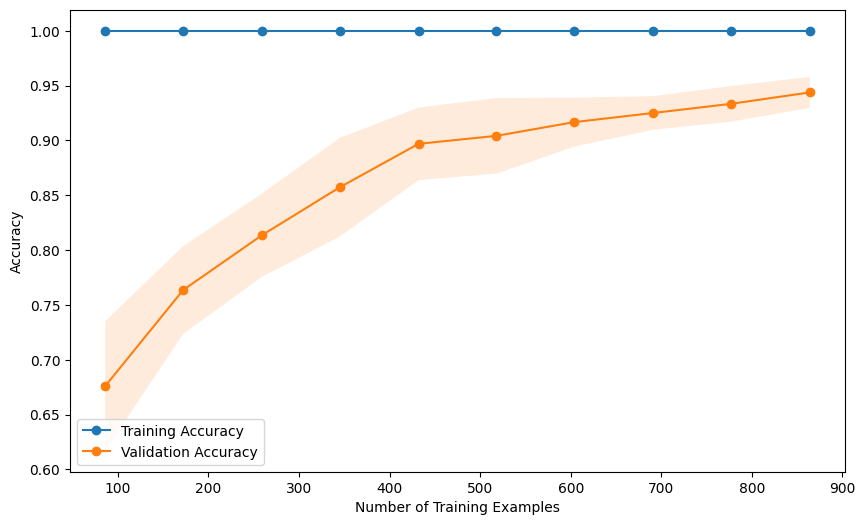

In [135]:
nb= MultinomialNB(alpha=1.0)
print("Learning curves of NB with ngram Vectorized Data")
plot_learning_curves(nb,X_train_ngram,y_train_enc)

### **ngram Vectorization + LR**

In [136]:
lr= LogisticRegression(multi_class='multinomial', solver='lbfgs',random_state=42)
results_ngram_lr= cross_validation(lr,X_train_ngram,y_train_enc,10)

Learning curves of LR with ngram Vectorized Data


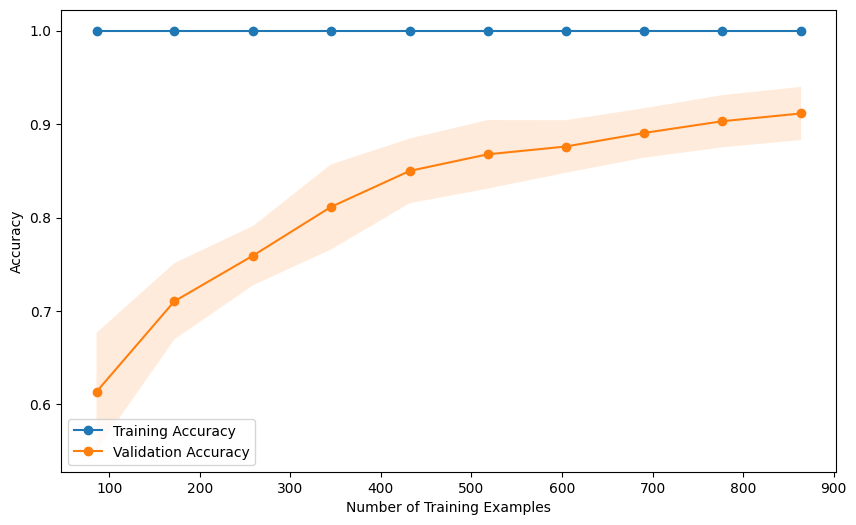

In [137]:
lr= LogisticRegression(multi_class='multinomial', solver='lbfgs',random_state=42)
print("Learning curves of LR with ngram Vectorized Data")
plot_learning_curves(lr,X_train_ngram,y_train_enc)

### **ngram Vectorization + Decision Tree**

In [138]:
dt= DecisionTreeClassifier(random_state=42)
results_ngram_dt= cross_validation(dt,X_train_ngram,y_train_enc,10)

Learning curves of DT with ngram Vectorized Data


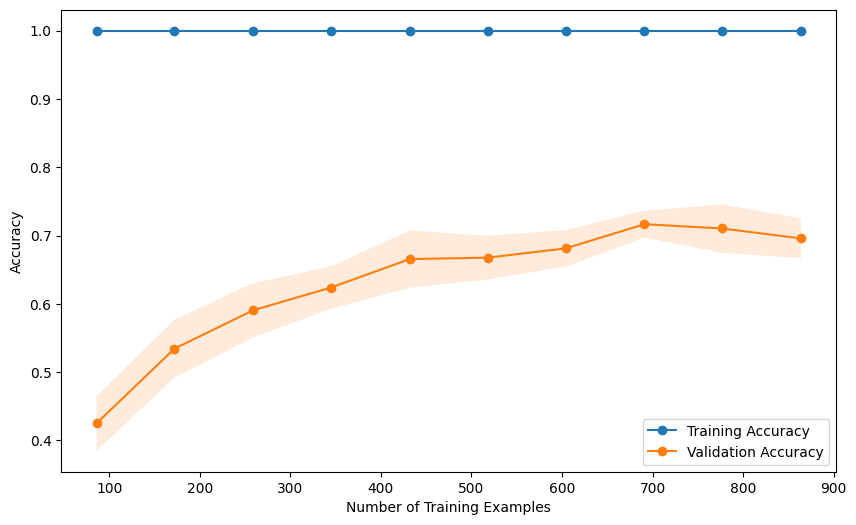

In [139]:
dt= DecisionTreeClassifier(random_state=42)
print("Learning curves of DT with ngram Vectorized Data")
plot_learning_curves(dt,X_train_ngram,y_train_enc)

### **ngram Vectorization + Random Forest**

In [140]:
rf= RandomForestClassifier(random_state=42)
results_ngram_rf= cross_validation(rf,X_train_ngram,y_train_enc,10)

Learning curves of RF with ngram Vectorized Data


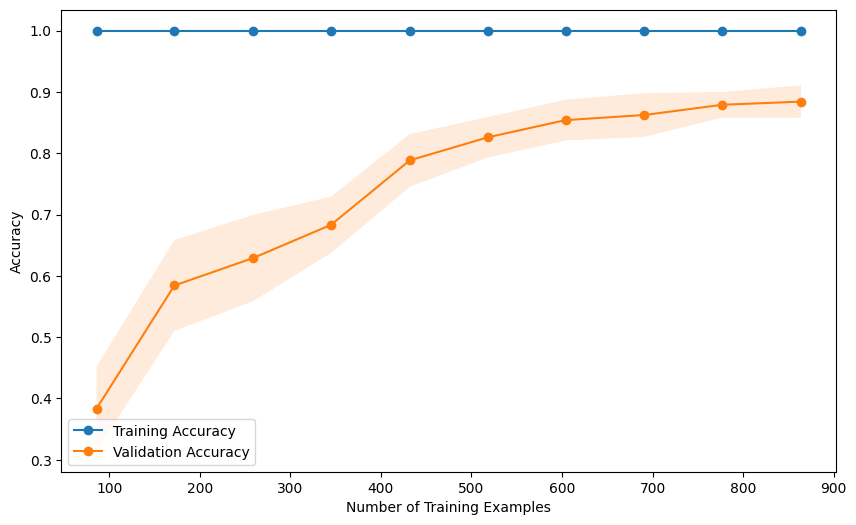

In [141]:
rf= RandomForestClassifier(random_state=42)
print("Learning curves of RF with ngram Vectorized Data")
plot_learning_curves(rf,X_train_ngram,y_train_enc)

### **Testing F1 and Accuracy Scores of the 5 classifiers with ngram Vectorization**

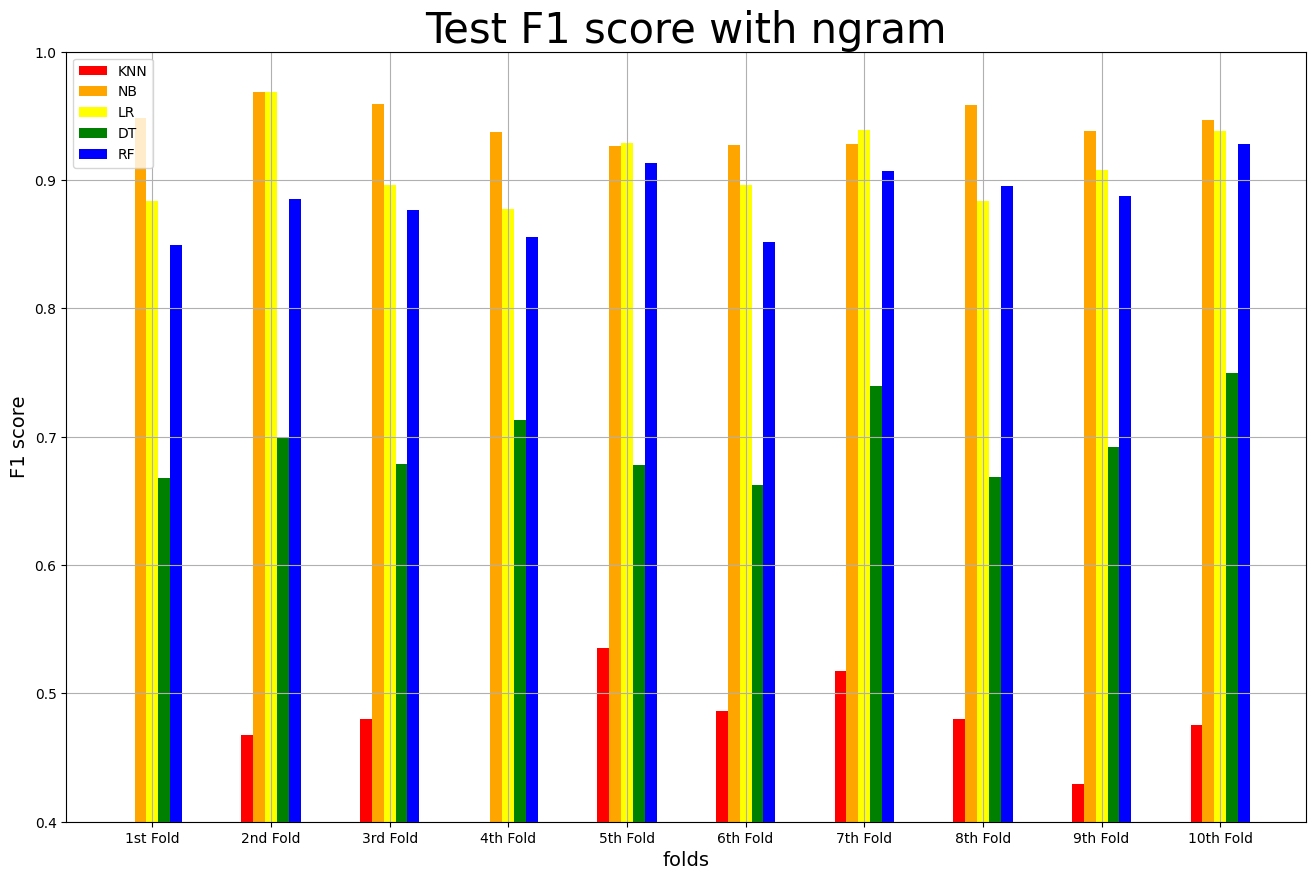

In [142]:
plot_comparison("folds", "F1 score", "Test F1 score with ngram", results_ngram_knn['Validation F1 scores'], results_ngram_nb['Validation F1 scores'], results_ngram_lr['Validation F1 scores'], results_ngram_dt['Validation F1 scores'], results_ngram_rf['Validation F1 scores'])

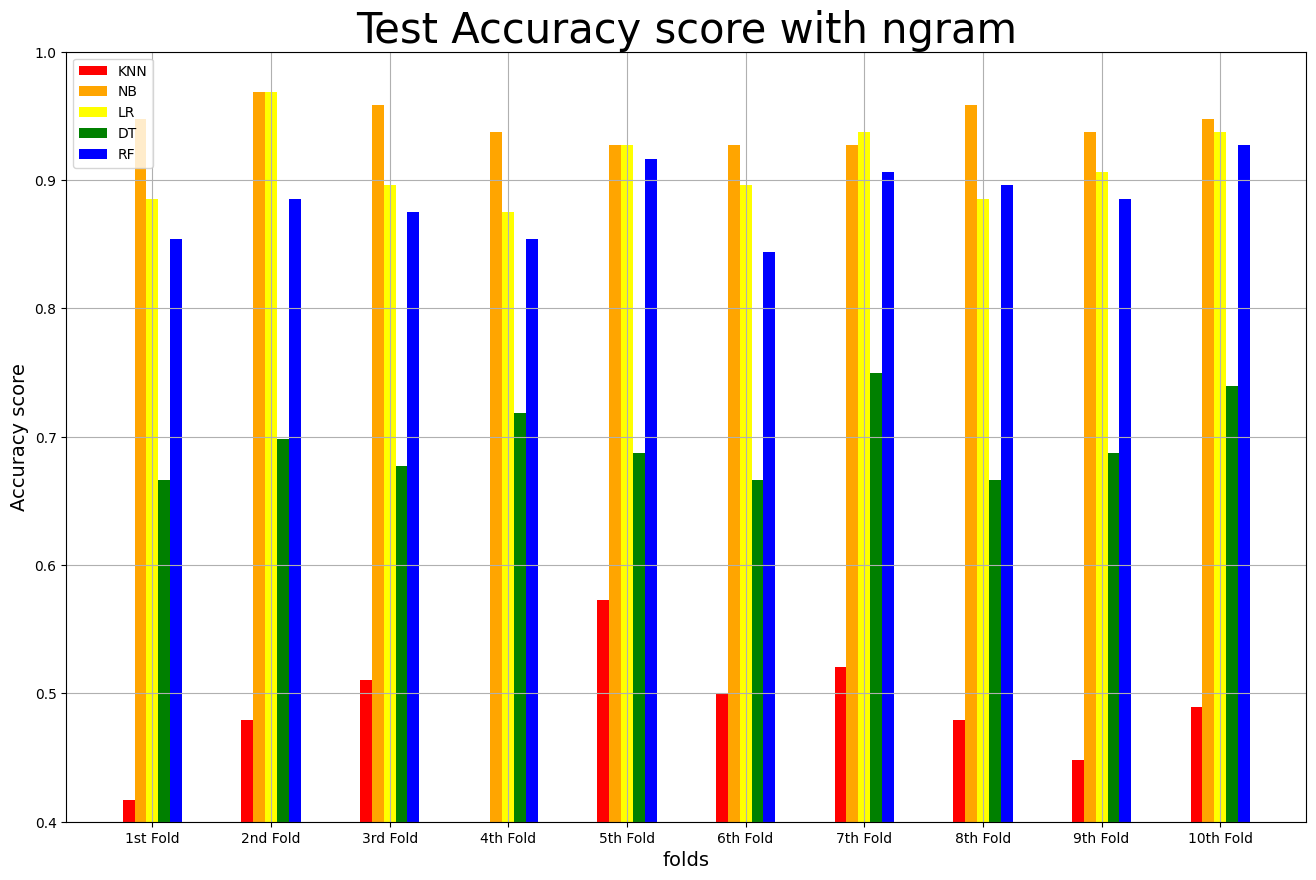

In [143]:
plot_comparison("folds", "Accuracy score", "Test Accuracy score with ngram", results_ngram_knn['Validation Accuracy scores'], results_ngram_nb['Validation Accuracy scores'], results_ngram_lr['Validation Accuracy scores'], results_ngram_dt['Validation Accuracy scores'], results_ngram_rf['Validation Accuracy scores'])

## **Classifying TFIDF vectorized data**

### **tfidf Vectorization + KNN**

In [144]:
knn= KNeighborsClassifier()
results_tfidf_knn= cross_validation(knn,X_train_tfidf,y_train_enc,10)

Learning curves of KNN with tfidf Vectorized Data


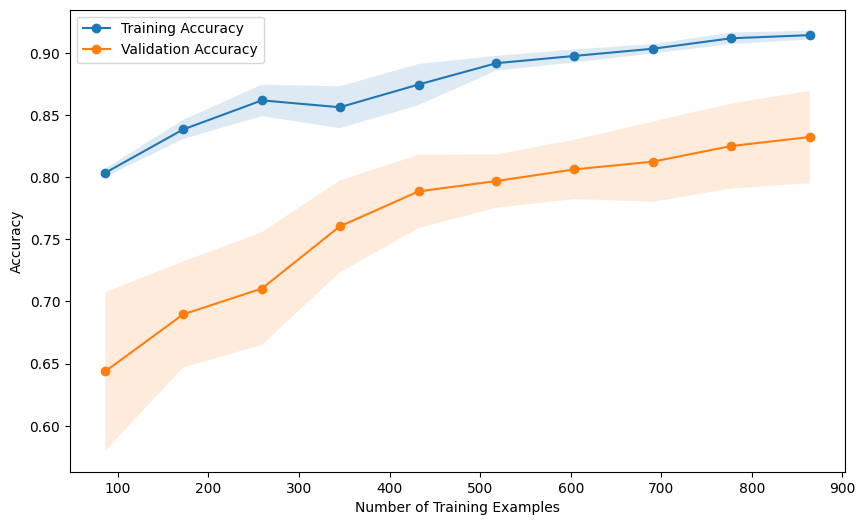

In [145]:
knn= KNeighborsClassifier()
print("Learning curves of KNN with tfidf Vectorized Data")
plot_learning_curves(knn,X_train_tfidf,y_train_enc)

### **tfidf Vectorization + NB**

In [146]:
nb= MultinomialNB(alpha=1.0)
results_tfidf_nb= cross_validation(nb,X_train_tfidf,y_train_enc,10)

Learning curves of NB with tfidf Vectorized Data


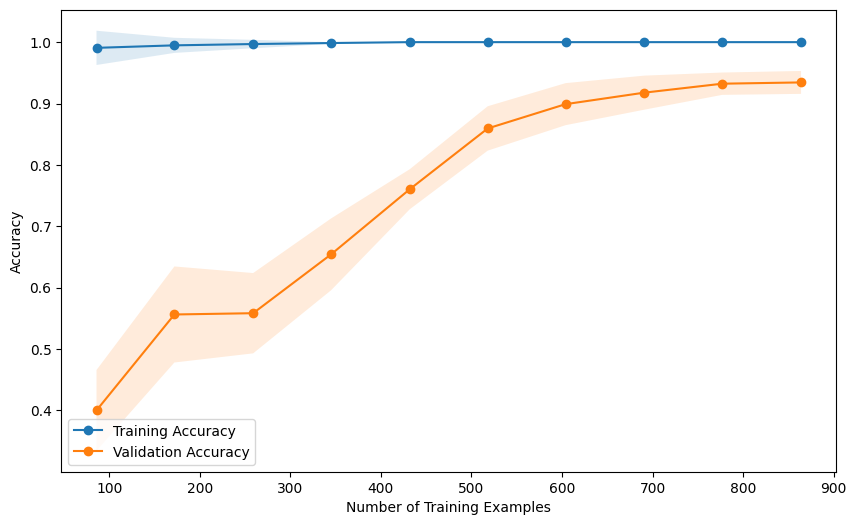

In [147]:
nb= MultinomialNB(alpha=1.0)
print("Learning curves of NB with tfidf Vectorized Data")
plot_learning_curves(nb,X_train_tfidf,y_train_enc)

### **tfidf Vectorization + lr**

In [148]:
lr= LogisticRegression(multi_class='multinomial', solver='lbfgs',random_state=42)
results_tfidf_lr= cross_validation(lr,X_train_tfidf,y_train_enc,10)

Learning curves of LR with tfidf Vectorized Data


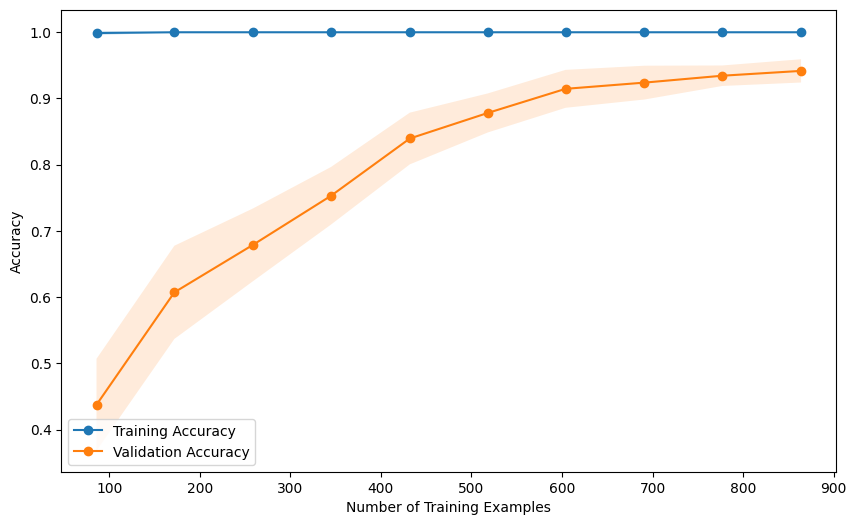

In [149]:
lr= LogisticRegression(multi_class='multinomial', solver='lbfgs',random_state=42)
print("Learning curves of LR with tfidf Vectorized Data")
plot_learning_curves(lr,X_train_tfidf,y_train_enc)

### **tfidf Vectorization + Decision Tree**

In [150]:
dt= DecisionTreeClassifier(random_state=42)
results_tfidf_dt= cross_validation(dt,X_train_tfidf,y_train_enc,10)

Learning curves of DT with tfidf Vectorized Data


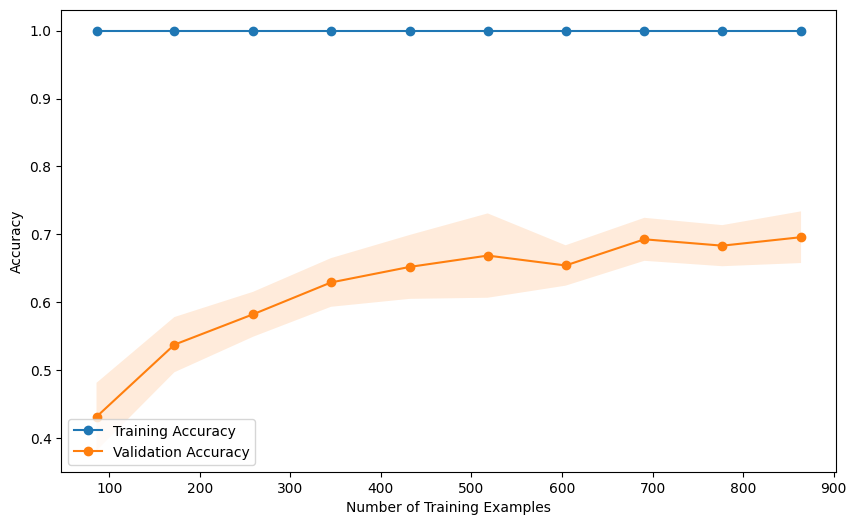

In [151]:
dt= DecisionTreeClassifier(random_state=42)
print("Learning curves of DT with tfidf Vectorized Data")
plot_learning_curves(dt,X_train_tfidf,y_train_enc)

### **tfidf Vectorization + Random Forest**

In [ ]:
rf= RandomForestClassifier(random_state=42)
results_tfidf_rf= cross_validation(rf,X_train_tfidf,y_train_enc,10)

In [ ]:
rf= RandomForestClassifier(random_state=42)
print("Learning curves of RF with tfidf Vectorized Data")
plot_learning_curves(rf,X_train_tfidf,y_train_enc)

### **Testing F1 and Accuracy Scpres of the 5 classifiers with tfidf Vectorization**

In [ ]:
plot_comparison("folds", "F1 score", "Test F1 score with tfidf", results_tfidf_knn['Validation F1 scores'], results_tfidf_nb['Validation F1 scores'], results_tfidf_lr['Validation F1 scores'], results_tfidf_dt['Validation F1 scores'], results_tfidf_rf['Validation F1 scores'])

In [ ]:
plot_comparison("folds", "Accuracy score", "Test Accuracy score with tfidf", results_tfidf_knn['Validation Accuracy scores'], results_tfidf_nb['Validation Accuracy scores'], results_tfidf_lr['Validation Accuracy scores'], results_tfidf_dt['Validation Accuracy scores'], results_tfidf_rf['Validation Accuracy scores'])

## **Summary of Performances - Champion model Analysis**

In [ ]:
mean_test_acc_BOW=pd.Series([results_BOW_knn['Mean Validation Accuracy'],results_BOW_nb['Mean Validation Accuracy'],results_BOW_lr['Mean Validation Accuracy'],results_BOW_dt['Mean Validation Accuracy'],results_BOW_rf['Mean Validation Accuracy']])
mean_test_acc_ngram=pd.Series([results_ngram_knn['Mean Validation Accuracy'],results_ngram_nb['Mean Validation Accuracy'],results_ngram_lr['Mean Validation Accuracy'],results_ngram_dt['Mean Validation Accuracy'],results_ngram_rf['Mean Validation Accuracy']])
mean_test_acc_tfidf=pd.Series([results_tfidf_knn['Mean Validation Accuracy'],results_tfidf_nb['Mean Validation Accuracy'],results_tfidf_lr['Mean Validation Accuracy'],results_tfidf_dt['Mean Validation Accuracy'],results_tfidf_rf['Mean Validation Accuracy']])

mean_test_acc= pd.DataFrame({'BOW': mean_test_acc_BOW,'Ngram': mean_test_acc_ngram, 'TFIDF': mean_test_acc_tfidf})
mean_test_acc.index= ['KNN','NB','LR','DT','RF']

In [ ]:
mean_test_f1_BOW=pd.Series([results_BOW_knn['Mean Validation F1 Score'],results_BOW_nb['Mean Validation F1 Score'],results_BOW_lr['Mean Validation F1 Score'],results_BOW_dt['Mean Validation F1 Score'],results_BOW_rf['Mean Validation F1 Score']])
mean_test_f1_ngram=pd.Series([results_ngram_knn['Mean Validation F1 Score'],results_ngram_nb['Mean Validation F1 Score'],results_ngram_lr['Mean Validation F1 Score'],results_ngram_dt['Mean Validation F1 Score'],results_ngram_rf['Mean Validation F1 Score']])
mean_test_f1_tfidf=pd.Series([results_tfidf_knn['Mean Validation F1 Score'],results_tfidf_nb['Mean Validation F1 Score'],results_tfidf_lr['Mean Validation F1 Score'],results_tfidf_dt['Mean Validation F1 Score'],results_tfidf_rf['Mean Validation F1 Score']])

mean_test_f1= pd.DataFrame({'BOW': mean_test_f1_BOW,'Ngram': mean_test_f1_ngram, 'TFIDF': mean_test_f1_tfidf})
mean_test_f1.index= ['KNN','NB','LR','DT','RF']

In [164]:
print('Mean Testing Accuracies:')
mean_test_acc

Mean Testing Accuracies:


,BOW,Ngram,TFIDF
KNN,60.416667,48.020833,83.229167
NB,94.166667,94.375000,93.437500
LR,90.833333,91.145833,94.166667
DT,69.895833,69.583333,69.583333
RF,88.229167,88.437500,86.354167


In [165]:
print('Mean Testing F1 Scores:')
mean_test_f1

Mean Testing F1 Scores:


,BOW,Ngram,TFIDF
KNN,59.993254,46.454432,82.891013
NB,94.172603,94.388937,93.458182
LR,90.900593,91.188275,94.198895
DT,69.684290,69.499087,69.372052
RF,88.249920,88.510903,86.245928


In [166]:
champ_model= MultinomialNB(alpha=1.0)
champ_model.fit(X_train_ngram,y_train_enc)

MultinomialNB()

In [167]:
champ_model_pred = champ_model.predict(X_test_ngram)

## **Bias and Variance of Champion Model**

In [ ]:
nb= MultinomialNB(alpha=1.0)
_, bias_ngram_nb, var_ngram_nb = bias_variance_decomp(nb, X_train_ngram.values, y_train_enc, X_test_ngram.values, y_test_enc, loss='0-1_loss', random_seed=42)
print('Bias of NB Classifier with N-gram vectorized data: {} \nVariance of NB Classifier with N-gram vectorized data: {}'.format(bias_ngram_nb,var_ngram_nb))

Bias of NB Classifier with N-gram vectorized data: 0.05416666666666667 
Variance of NB Classifier with N-gram vectorized data: 0.04964583333333333


## **Confusion Matrix of Champion Model**

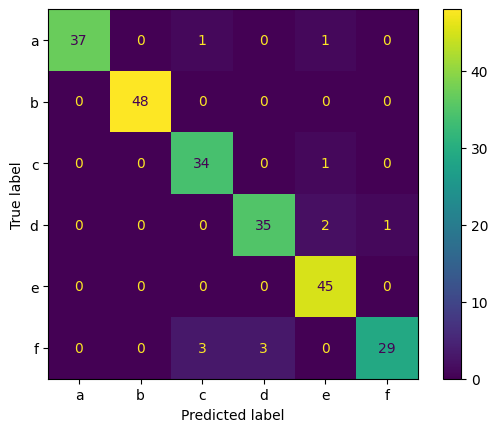

In [168]:
compute_confusion_matrix(y_test_enc,champ_model_pred)

## **Error Analysis**


In [173]:
X_test_misclassified= X_test[y_test_enc!=champ_model_pred]

In [179]:
X_test_misclassified_ngram= X_test_ngram[y_test_enc!=champ_model_pred]

In [180]:
X_test_misclassified_ngram

,101,101 suppose,103,103 also,108,108 gr,109,109 suppose,11,11 begin,...,álvaro though,ægean,ægean described,æneas,æneas worse,μέγαρα,μέγαρα covered,πλωτῇ,πολυδαίδαλος,πολυδαίδαλος put
74,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
150,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
210,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [174]:
X_test_misclassified

,Partition_lemmatized
74,stick perhaps eminent sordid vile light discer...
80,year believe disgraceful action age took place...
94,unmasked shall prosecute judge blind drunk bel...
95,know mother little let put away whim welcome b...
100,song lamenting elegy drinking crystal water sp...
108,liked looking great carthorse long mane thick ...
129,three go arminarm linger behind alone follow l...
150,matter upset wanted make acquaintance talked l...
196,personality sound worth laureate 1619 growing ...
210,semyon zaharovitch service receiving salary sa...


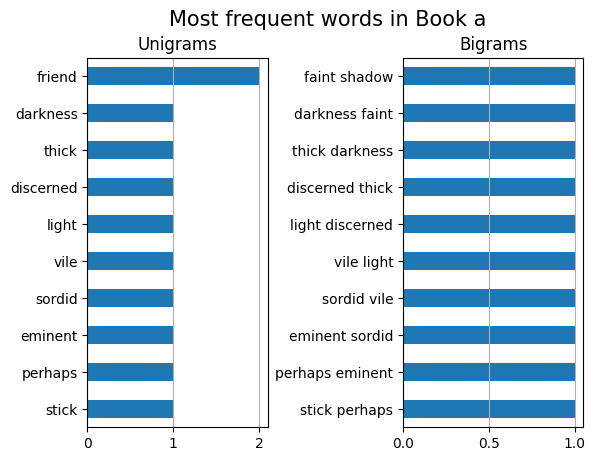

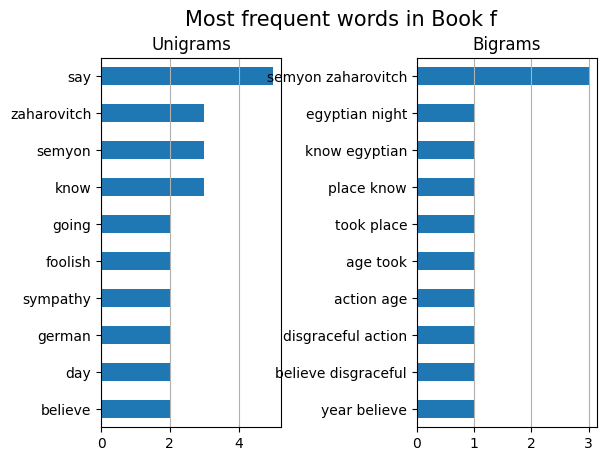

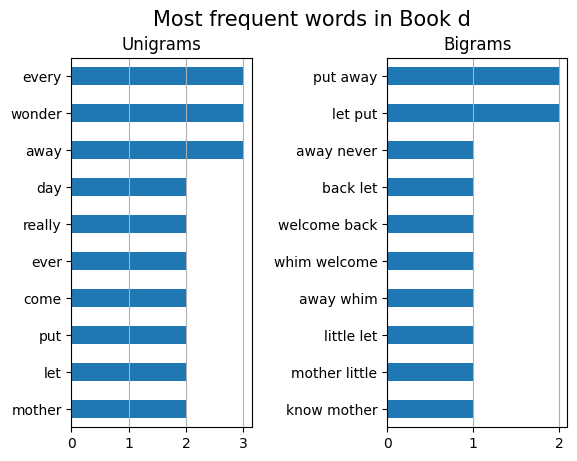

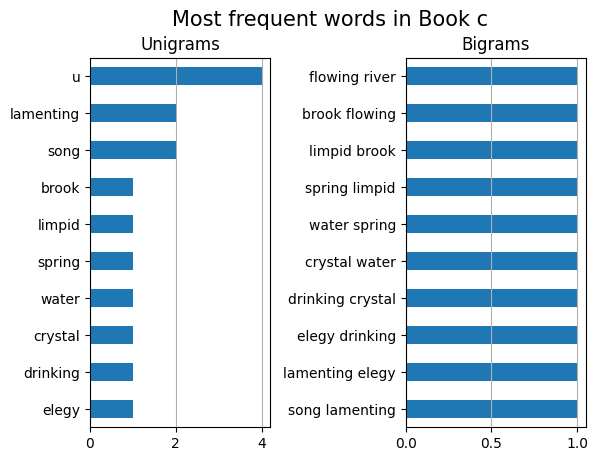

In [178]:
top= 10
for y in y_test_misclassified['Label'].unique():
  corpus = X_test_misclassified[y_test_misclassified['Label']==y]['Partition_lemmatized']
  lst_tokens = get_tokens(corpus.str.cat(sep=" "))
  fig, ax = plt.subplots(nrows=1, ncols=2)
  fig.suptitle("Most frequent words in Book {}".format(y), fontsize=15)
  ## unigrams
  dic_words_freq = nltk.FreqDist(lst_tokens)
  dtf_uni = pd.DataFrame(dic_words_freq.most_common(),columns=["Word","Freq"])
  dtf_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(kind="barh", title="Unigrams", ax=ax[0],legend=False).grid(axis='x')
  ax[0].set(ylabel=None)
  ## bigrams
  dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
  dtf_bi = pd.DataFrame(dic_words_freq.most_common(),columns=["Word","Freq"])
  dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(string for string in x) )
  dtf_bi.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(kind="barh", title="Bigrams", ax=ax[1],legend=False).grid(axis='x')
  ax[1].set(ylabel=None)
  plt.subplots_adjust(wspace=0.75)
  plt.show()

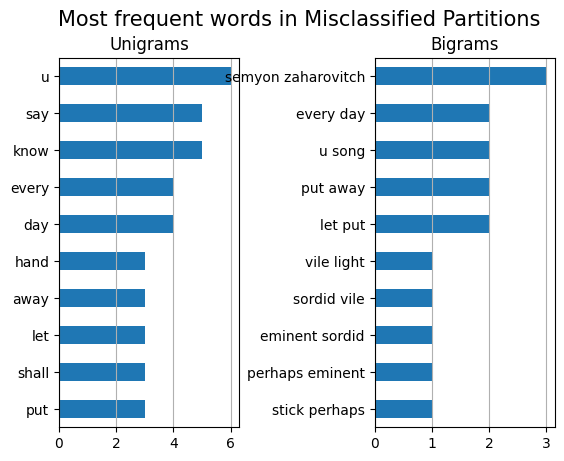

In [175]:
top= 10
corpus = X_test_misclassified['Partition_lemmatized']
lst_tokens = get_tokens(corpus.str.cat(sep=" "))
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle("Most frequent words in Misclassified Partitions",fontsize=15)
## unigrams
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(),columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(kind="barh", title="Unigrams", ax=ax[0],legend=False).grid(axis='x')
ax[0].set(ylabel=None)
## bigrams
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(),columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(string for string in x) )
dtf_bi.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(kind="barh", title="Bigrams", ax=ax[1],legend=False).grid(axis='x')
ax[1].set(ylabel=None)
plt.subplots_adjust(wspace=0.75)
plt.show()

In [194]:
d = {
    'and': [2, 0, 1, 3],
    'what': [0, 1, 2, 0],
    'how': [1, 3, 0, 2],
}

df = pd.DataFrame(d)
df

,and,what,how
0,2,0,1
1,0,1,3
2,1,2,0
3,3,0,2


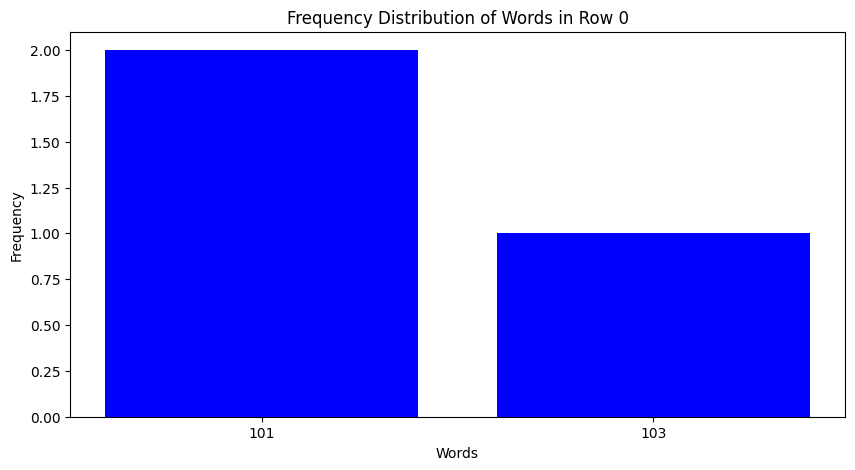

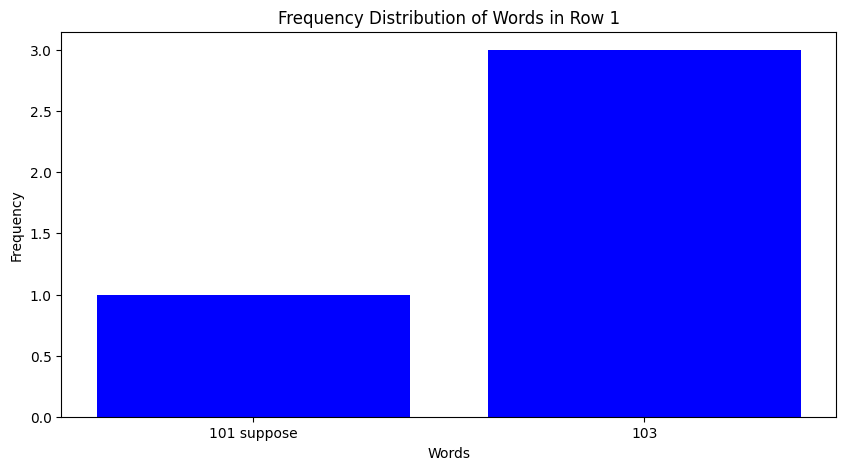

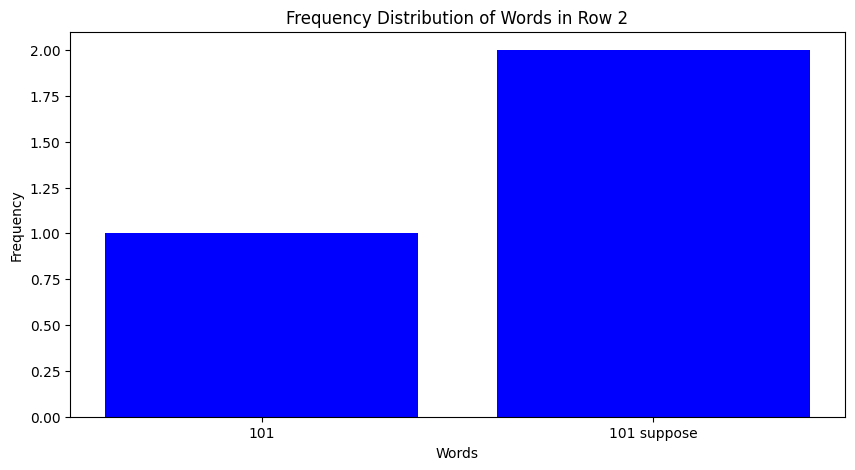

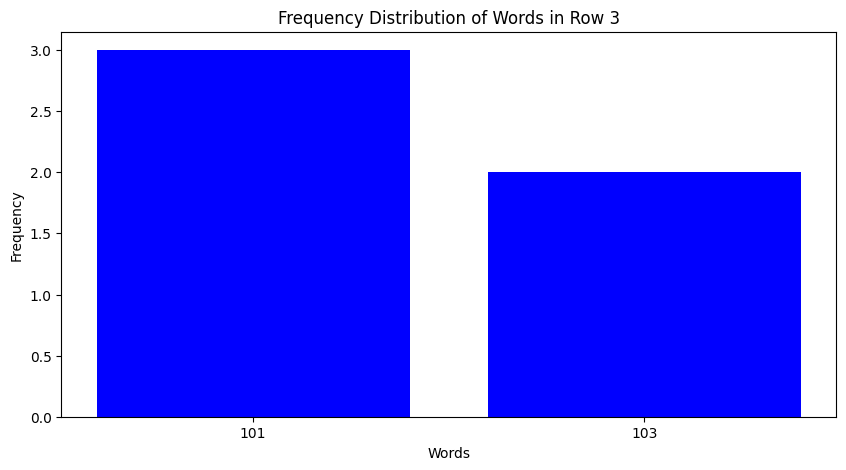

In [195]:
miscliassfied = pd.DataFrame()
misclassified_indices = [i for i in range(len(y_test_enc)) if i < len(champ_model_pred) and y_test_enc[i] != champ_model_pred[i]]


misclassified_df = X_train_ngram.loc[misclassified_indices]
#df_t = misclassified_df.T
#word_count_list = [(word, count) for col in misclassified_df.columns for word, count in zip(misclassified_df.index, misclassified_df[col])]
#fdist_list = [FreqDist([word for word in misclassified_df.index for _ in range(misclassified_df[col][word])]) for col in misclassified_df.columns]

# Plot the counts of each word for each column
for index, row in df.iterrows():
    words = [word for word, count in zip(misclassified_df.columns, row) for _ in range(count)]
    fdist = nltk.FreqDist(words)

    plt.figure(figsize=(10, 5))
    plt.bar(fdist.keys(), fdist.values(), color='blue')
    plt.title(f'Frequency Distribution of Words in Row {index}')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()



##**Breaking down Champion model- decreasing accuracy**##

Adding more books of the same authors but different genre

In [196]:
url1 = 'https://www.gutenberg.org/cache/epub/3695/pg3695.txt'
title1= 'Every Man out of His Humour'
author1= 'Ben Jonson'
label1= 'a'
dict1= {'title':title1, 'author':author1, 'url':url1, 'label':label1}

url2 = 'https://www.gutenberg.org/cache/epub/1658/pg1658.txt'
title2= 'Phaedo'
author2= 'Plato'
label2= 'b'
dict2= {'title':title2, 'author':author2, 'url':url2, 'label':label2}

url3 = 'https://www.gutenberg.org/cache/epub/63404/pg63404.txt'
title3= 'Galatea'
author3= 'Miguel de Cervantes Saavedra'
label3= 'c'
dict3= {'title':title3, 'author':author3, 'url':url3, 'label':label3}

url4 = 'https://www.gutenberg.org/cache/epub/19337/pg19337.txt'
title4= 'A Christmas Carol'
author4= 'Charles Dickens'
label4= 'd'
dict4= {'title':title4, 'author':author4, 'url':url4, 'label':label4}

url5 = 'https://www.gutenberg.org/cache/epub/22382/pg22382.txt'
title5= 'The Iliad'
author5= 'Homer'
label5= 'e'
dict5= {'title':title5, 'author':author5, 'url':url5, 'label':label5}

url6 = 'https://www.gutenberg.org/cache/epub/8117/pg8117.txt'
title6= 'The Possessed (The Devils)'
author6= 'Fyodor Dostoyevsky'
label6= 'f'
dict6= {'title':title6, 'author':author6, 'url':url6, 'label':label6}

books_details= [dict1, dict2, dict3, dict4,dict5, dict6]
books_details

[{'title': 'Every Man out of His Humour',
  'author': 'Ben Jonson',
  'url': 'https://www.gutenberg.org/cache/epub/3695/pg3695.txt',
  'label': 'a'},
 {'title': 'Phaedo',
  'author': 'Plato',
  'url': 'https://www.gutenberg.org/cache/epub/1658/pg1658.txt',
  'label': 'b'},
 {'title': 'Galatea',
  'author': 'Miguel de Cervantes Saavedra',
  'url': 'https://www.gutenberg.org/cache/epub/63404/pg63404.txt',
  'label': 'c'},
 {'title': 'A Christmas Carol',
  'author': 'Charles Dickens',
  'url': 'https://www.gutenberg.org/cache/epub/19337/pg19337.txt',
  'label': 'd'},
 {'title': 'The Iliad',
  'author': 'Homer',
  'url': 'https://www.gutenberg.org/cache/epub/22382/pg22382.txt',
  'label': 'e'},
 {'title': 'The Possessed (The Devils)',
  'author': 'Fyodor Dostoyevsky',
  'url': 'https://www.gutenberg.org/cache/epub/8117/pg8117.txt',
  'label': 'f'}]

In [215]:
new_data= extract_and_save(books_details,num_partitions=200,num_words_per_partition=100)

In [216]:
new_data

,Book Title,Book Author,Label,Partition
0,Every Man out of His Humour,Ben Jonson,a,in Jonson 's time 20s . or 22s . PIECES OF EIG...
1,Every Man out of His Humour,Ben Jonson,a,you might very well stand for a gentleman : I ...
2,Every Man out of His Humour,Ben Jonson,a,amount ; right moment ; `` set in the -- '' me...
3,Every Man out of His Humour,Ben Jonson,a,"for placing snuffers in ( Halliwell ) SOCK , s..."
4,Every Man out of His Humour,Ben Jonson,a,he 's a fellow of a strange nature . Now does ...
...,...,...,...,...
1195,The Possessed (The Devils),Fyodor Dostoyevsky,f,honourable name . That 's just what I had to p...
1196,The Possessed (The Devils),Fyodor Dostoyevsky,f,"are always the same .... '' '' I know , and I ..."
1197,The Possessed (The Devils),Fyodor Dostoyevsky,f,day . He had made her acquaintance in Switzerl...
1198,The Possessed (The Devils),Fyodor Dostoyevsky,f,"what was of the utmost value , he judged of th..."


In [217]:
new_data['Partition_stemmed']= new_data['Partition'].apply(lambda x: clean_text_stem(x))
new_data['Partition_lemmatized']= new_data['Partition'].apply(lambda x: clean_text_lem(x))

In [218]:
new_data

,Book Title,Book Author,Label,Partition,Partition_stemmed,Partition_lemmatized
0,Every Man out of His Humour,Ben Jonson,a,in Jonson 's time 20s . or 22s . PIECES OF EIG...,jonson time 20 22 piec eight spanish coin pias...,jonson time 20 22 piece eight spanish coin pia...
1,Every Man out of His Humour,Ben Jonson,a,you might very well stand for a gentleman : I ...,might well stand gentleman know mani sogliardo...,might well stand gentleman know many sogliardo...
2,Every Man out of His Humour,Ben Jonson,a,amount ; right moment ; `` set in the -- '' me...,amount right moment set mean uncertain nice su...,amount right moment set meaning uncertain nice...
3,Every Man out of His Humour,Ben Jonson,a,"for placing snuffers in ( Halliwell ) SOCK , s...",place snuffer halliwel sock shoe worn comic ac...,placing snuffer halliwell sock shoe worn comic...
4,Every Man out of His Humour,Ben Jonson,a,he 's a fellow of a strange nature . Now does ...,fellow strang natur calm humour plot store wor...,fellow strange nature calm humour plot store w...
...,...,...,...,...,...,...
1195,The Possessed (The Devils),Fyodor Dostoyevsky,f,honourable name . That 's just what I had to p...,honour name put speak care liputin stepan trof...,honourable name put speaking careful liputin s...
1196,The Possessed (The Devils),Fyodor Dostoyevsky,f,"are always the same .... '' '' I know , and I ...",alway know believ mean noth sometim one worri ...,always know believe mean nothing sometimes one...
1197,The Possessed (The Devils),Fyodor Dostoyevsky,f,day . He had made her acquaintance in Switzerl...,day made acquaint switzerland certainli someth...,day made acquaintance switzerland certainly so...
1198,The Possessed (The Devils),Fyodor Dostoyevsky,f,"what was of the utmost value , he judged of th...",utmost valu judg remark good sens must mention...,utmost value judged remarkable good sense must...


In [223]:
X_train_new, X_test_new, y_train_new, y_test_new= train_test_split(new_data['Partition_lemmatized'],new_data['Label'], test_size= 0.2, shuffle= True,random_state=42)

In [224]:
X_train_new.to_csv('X_train_new.csv', index=False, header=True, encoding= 'utf-8-sig')
X_test_new.to_csv('X_test_new.csv', index=False, header=True, encoding= 'utf-8-sig')
y_train_new.to_csv('y_train_new.csv', index=False, header=True, encoding= 'utf-8-sig')
y_test_new.to_csv('y_test_new.csv', index=False, header=True, encoding= 'utf-8-sig')

In [225]:
X_train_new= pd.read_csv('X_train_new.csv', encoding= 'utf-8-sig')
X_test_new= pd.read_csv('X_test_new.csv', encoding= 'utf-8-sig')
y_train_new= pd.read_csv('y_train_new.csv', encoding= 'utf-8-sig')
y_test_new= pd.read_csv('y_test_new.csv', encoding= 'utf-8-sig')

In [229]:

X_train_ngram_new= ngram_vect.transform(X_train_new['Partition_lemmatized'])
X_test_ngram_new= ngram_vect.transform(X_test_new['Partition_lemmatized'])

# Expand the sparse matrix to a collection of arrays and store collection of arrays into a data frame
X_train_ngram_new= pd.DataFrame(X_train_ngram_new.toarray())
X_test_ngram_new= pd.DataFrame(X_test_ngram_new.toarray())
X_train_ngram_new.columns= ngram_vect.get_feature_names_out()
X_test_ngram_new.columns= ngram_vect.get_feature_names_out()

In [230]:
le = LabelEncoder()

y_train_enc_new = le.fit_transform(y_train_new.values.ravel())
y_test_enc_new = le.transform(y_test_new.values.ravel())

In [231]:
champ_model_pred_new= champ_model.predict(X_test_ngram_new)

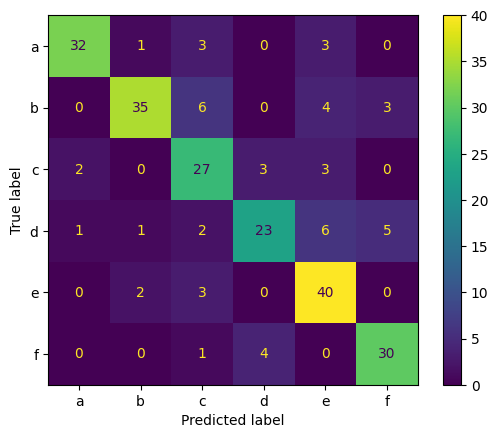

In [232]:
compute_confusion_matrix(y_test_enc_new,champ_model_pred_new)


In [233]:
print(classification_report(y_test_enc_new,champ_model_pred_new))

              precision    recall  f1-score   support

           0       0.91      0.82      0.86        39
           1       0.90      0.73      0.80        48
           2       0.64      0.77      0.70        35
           3       0.77      0.61      0.68        38
           4       0.71      0.89      0.79        45
           5       0.79      0.86      0.82        35

    accuracy                           0.78       240
   macro avg       0.79      0.78      0.78       240
weighted avg       0.79      0.78      0.78       240



In [234]:
print(f1_score(y_test_enc_new,champ_model_pred_new,average = "macro"))

0.7768714786147092
